# Lesson 8: Time Series Forecasting

## I. Introduction

Welcome to this lesson on time series forecasting using deep learning. In this lesson, you will learn how to train deep neural networks to forecast time series.

It will be a hands-on lesson. So you'll get to train the neural networks yourself, and make them predict the future.

In this first section, I'll start by introducing what time series are. Let's get started.

Time series are everywhere. You've seen them in stock prices.

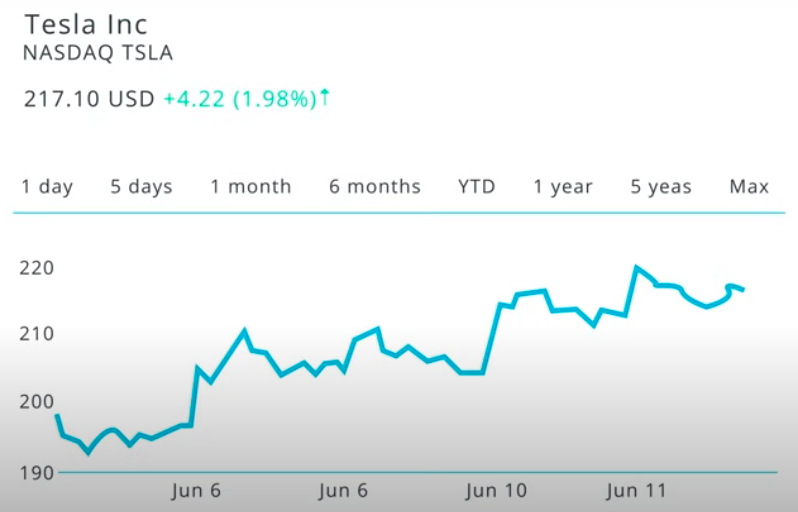

You've seen them in weather data.

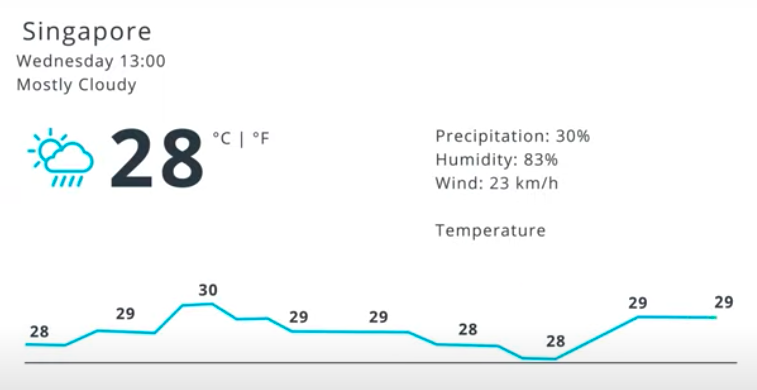

You've seen them in historical trends (e.g., Moore's Law below).

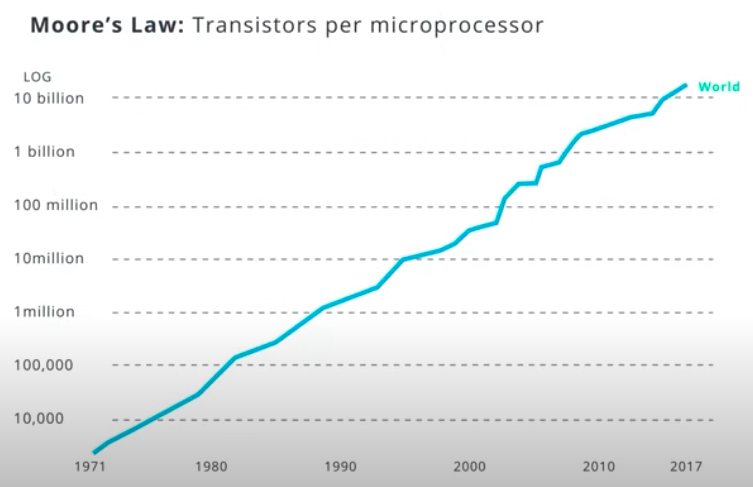

Then there are demand graphs (e.g., electricity demand below).

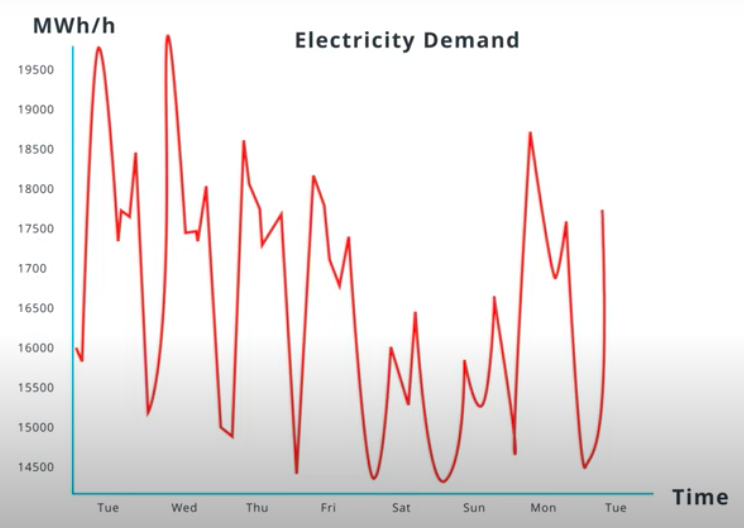

And even audio samples.

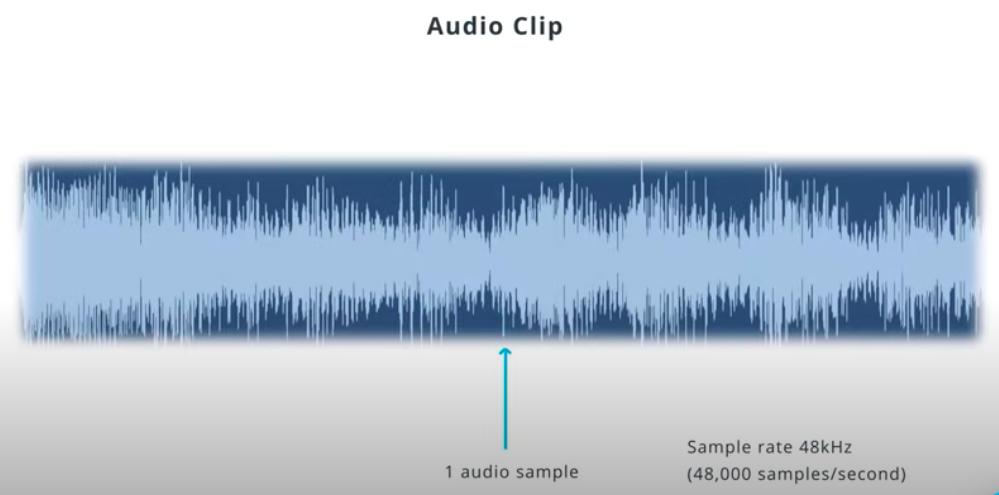

I could go on all day.

So what is a time series? It's an ordered sequence of values, usually equally spaced over time, e.g., every year, day, second, or even every few microseconds (like in the audio clip example).

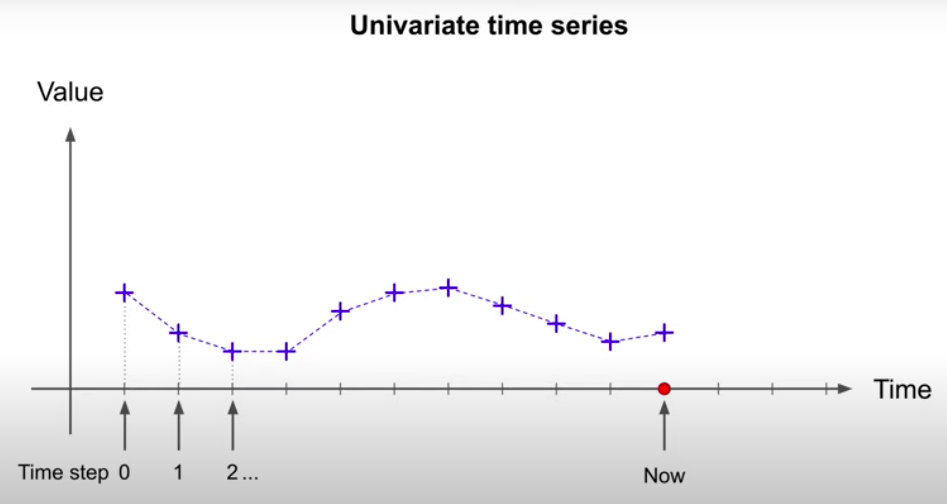

In all the examples I've listed so far, there is a single value at each timestamp. These time series are called univariate.

Now, some time series have multiple values at each timestamp. They are called multivariate time series. It could have two values, three values, or more.

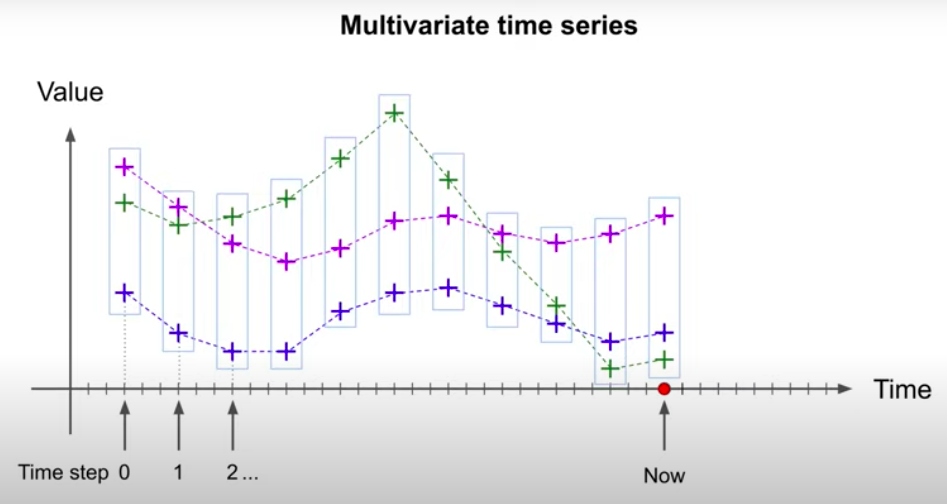

**Note:** The above time series has 3 dimensions. You could also think of this time series as having 3 channels. This is akin to a token in NLP having 3 embedding dimensions (i.e., the embedding vector for each token having a length of 3).

Here are a few examples. The birth rate and death rate in Japan over time can be treated as two separate univariate time series. But if you want to study how these values are related through time, then it's best to think of them as a single multivariate time series with two values at each timestamp.

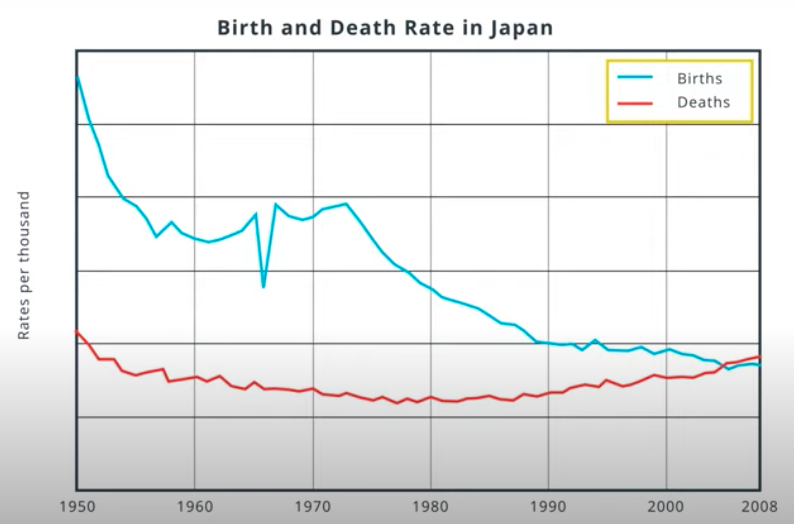

Another example is the increase in concentration of CO2 in the atmosphere over time, and the increase in global temperature of our planet. This is also a multivariate time series.

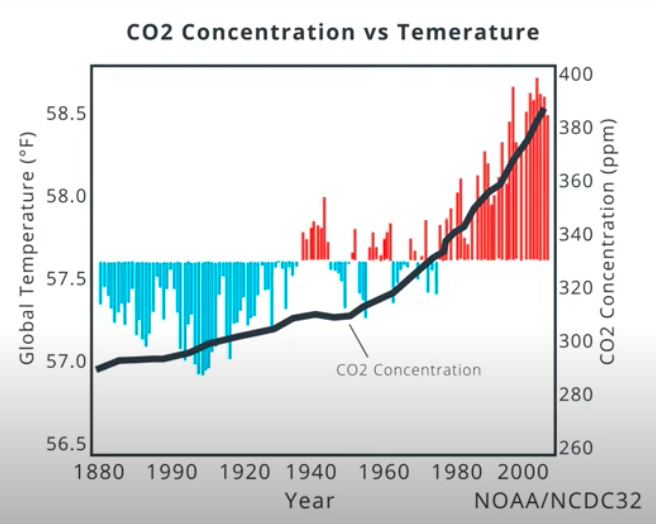

A stereo audio clip also has two values at each timestamp - one for the left audio channel, and one for the right.

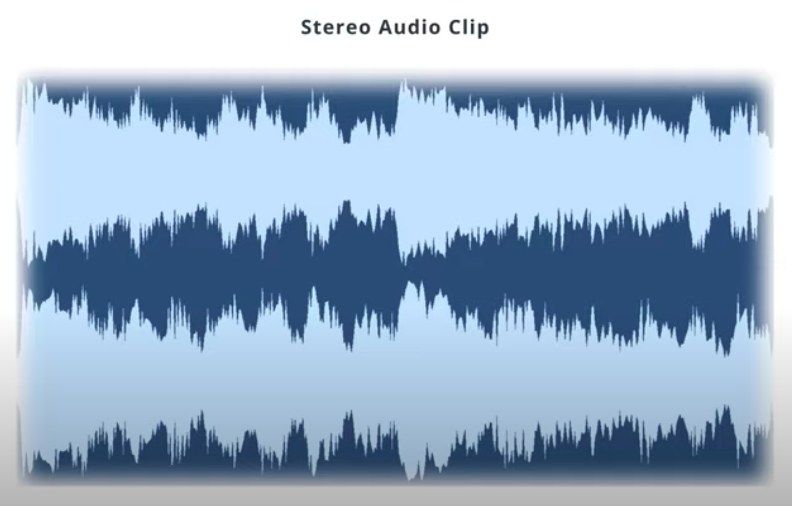

A trickier example is the path of a car. At each timestamp, the car has two GPS coordinates - the latitude and the longitude.

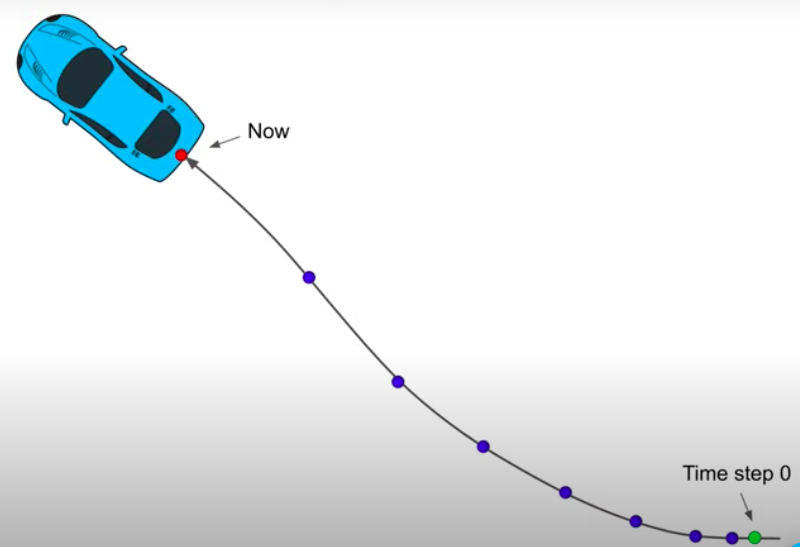

Notice that the car accelerated over time. So the positions at two consecutive timestamps are getting more and more spread apart. Let's plot the latitude and the longitude over time, and see what we get.

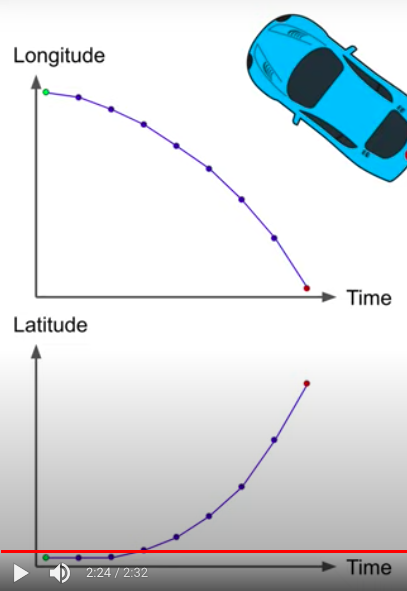

That's our multivariate time series! As the car is heading North-West, we can see the latitude go up over time, and the longitude go down.

## II. Applications

As we can see, time series can be used to analyse just about anything that evolves over time. Time series analysis has plenty of applications:

1. **The most obvious application is predicting the future**, which is called forecasting. For example, you could forecast stock prices and become rich.

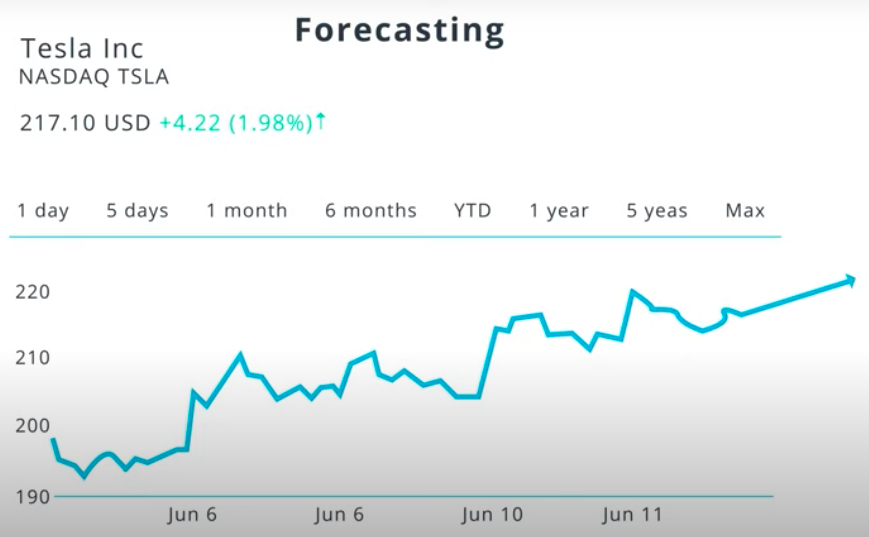

Or you may forecast temperature, or how much of a product you should manufacture to meet the demand.

2. But **you may also want to predict the past**. This might be useful if there is missing or corrupted data in the time series.

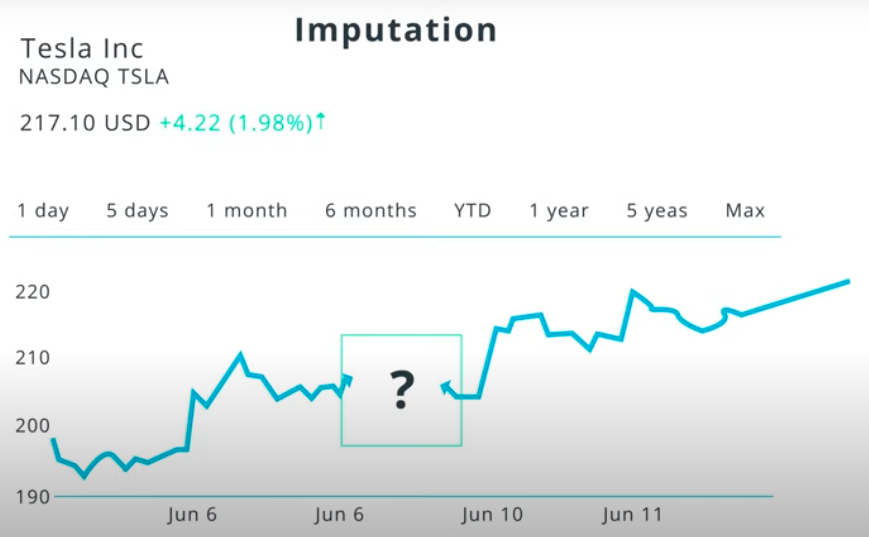

This is called imputation. It's akin to masked language modeling.

3. Or **maybe you're interested in the underlying process that generated the time series**. For example, you could study brain waves to better **understand** sleep cycles.

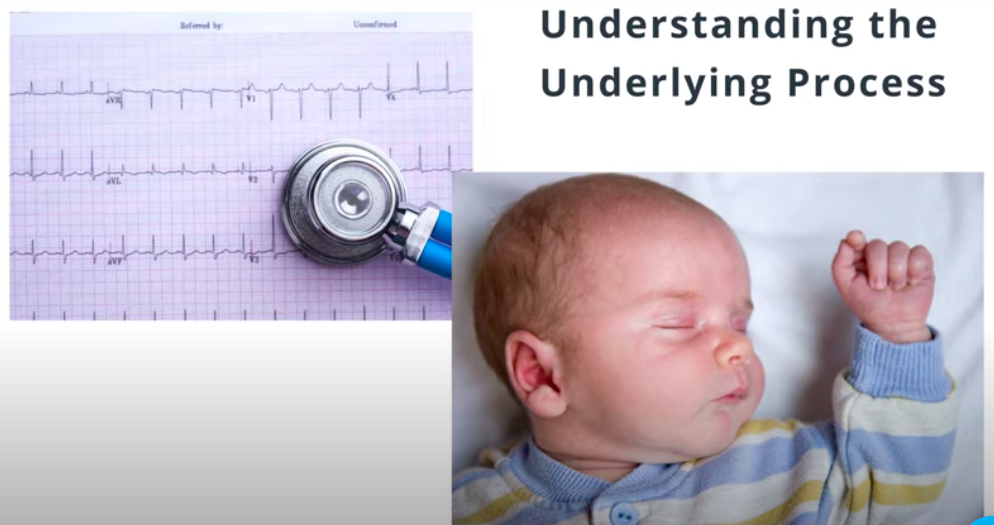

4. **Time series analysis can also be used to detect anomalies.** For example, you could monitor a website's traffic to detect abnormal patterns of activity, such as spam or denial of service attacks.

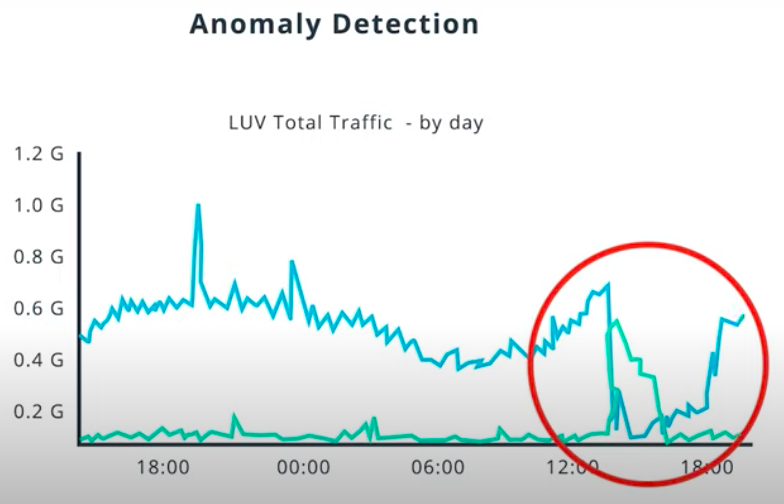

In this course, we will focus on forecasting. But the tools we will discuss can be used for any of the above four tasks I've listed.

In the next section, we'll look at common patterns found in time series, and how to describe them.

## III. Common Patterns

Time series come in all shapes and sizes. But some patterns are more common than others. So it's useful to recognize them.

For example, many time series gradually drift up or down.

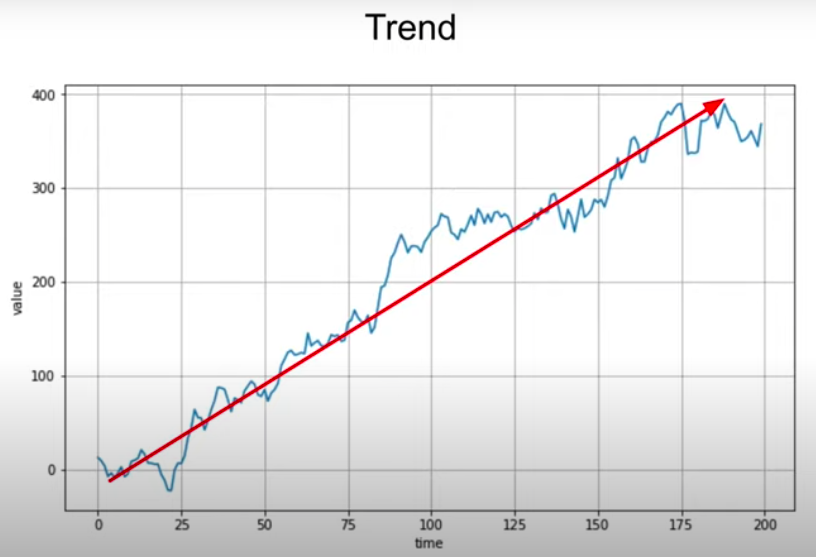

This is called a trend (and in this case an upward trend).

The following time series has some seasonality.

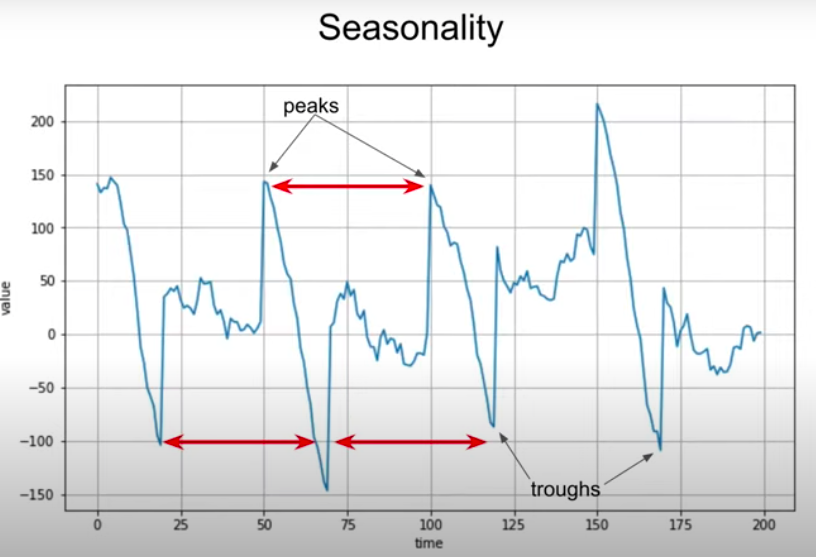

This is when **patterns (in particular peaks and troughs) repeat at predictable intervals**. For example:

- Gift sales jump up every winter in the holiday season.
- Temperature drops every night.
- There is more traffic during the rush hour every day.

Of course, some time series have both trend and seasonality.

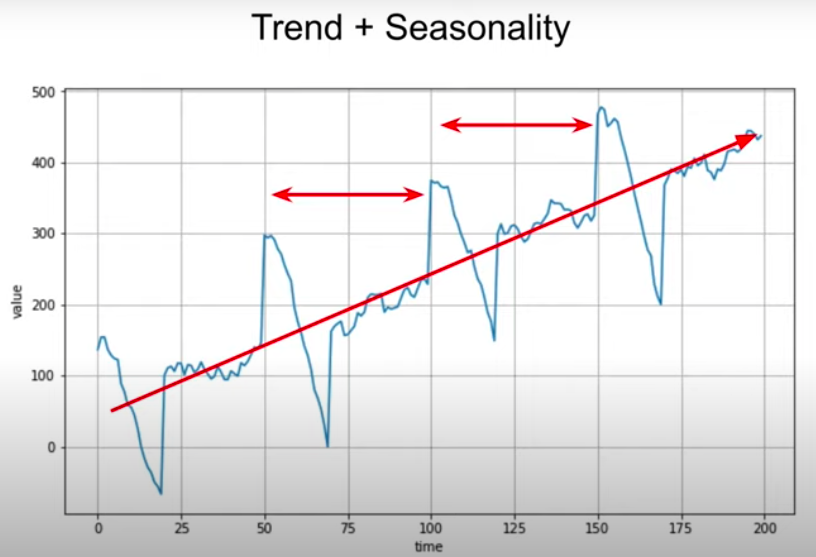

On the other hand, some time series are just completely unpredictable.

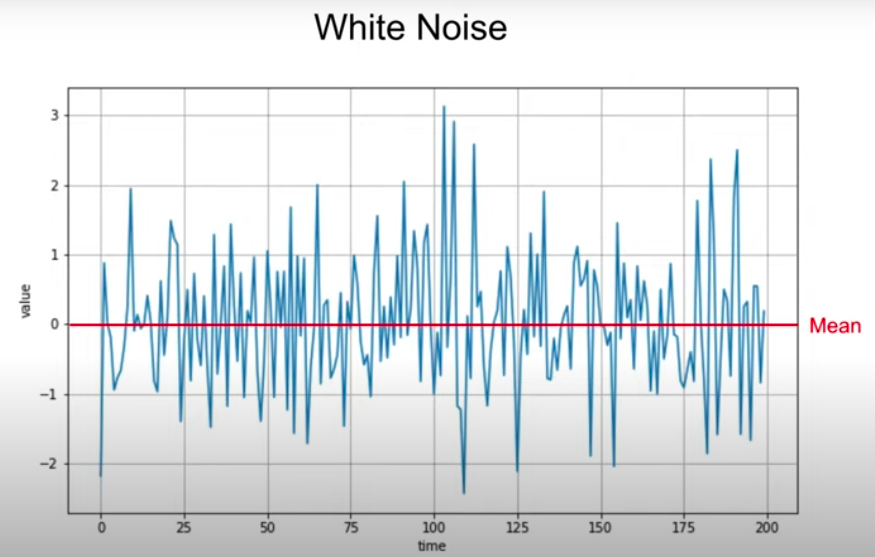

This one was generated by picking a random number at each step. This produces *white noise*. The best you can do with this is to **identify the probability distribution, and find its parameters**. For example, in this case, it's a Gaussian distribution with mean 0 and variance 1. You can see this if you plot a histogram of all the values. It will look like a bell curve. With a time series like this, **you will usually want to forecast the mean**.

Let's add all this together.

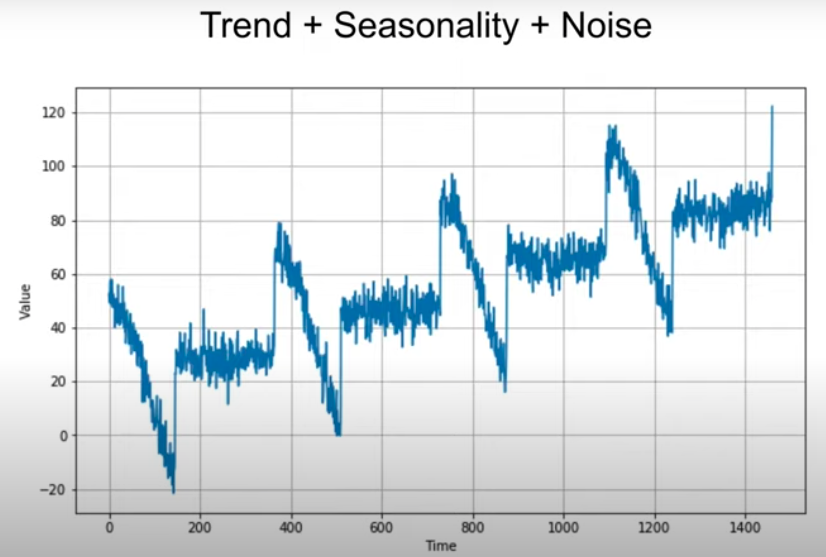

We get a time series with trend, seasonality and noise. This is realistic enough for now. Let's try to forecast this time series.

## IV. Colab: Common Patterns

**Note:** Since neural networks rely on stochasticity (i.e., randomness) to initialize their parameters, and gradient descent selects random batches of training data at each iteration, it's perfectly normal if the outputs you see when you run the Colabs are slightly different from those shown in the videos.

### Setup

In this notebook, we'll just use NumPy and Matplotlib.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We'll use the `plot_series` function to display the time series that we'll build. It takes a 1D array `time` (of integers) containing the time steps (0, 1, 2, ...), another 1D array `series` containing the values of the time series at the given time steps, and a few other parameters.

In [2]:
def plot_series(time, series, format='-', start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    if label is not None:
        plt.legend(fontsize=14)
    plt.grid(True)

Inside `plot_series`, we call the `plt.plot` function to display the time series, giving it the time steps and the values of the time series.

### Trend and Seasonality

The `trend` function defines a trend. It takes the time steps and a slope, and it just multiplies them together.

In [3]:
def trend(time, slope=0):
    return slope * time

The function is very simple. It just gives us a linear trend.

There are other shapes of trend that are possible (such as exponential trend), but we'll look at linear trend here.

In [4]:
time = np.arange(4 * 365 + 1) # 1 is added since every four years there is a leap year.
time

array([   0,    1,    2, ..., 1458, 1459, 1460])

**Note:** Each unit of time is a day.

In [5]:
baseline = 10
series = baseline + trend(time, 0.1)
series

array([ 10. ,  10.1,  10.2, ..., 155.8, 155.9, 156. ])

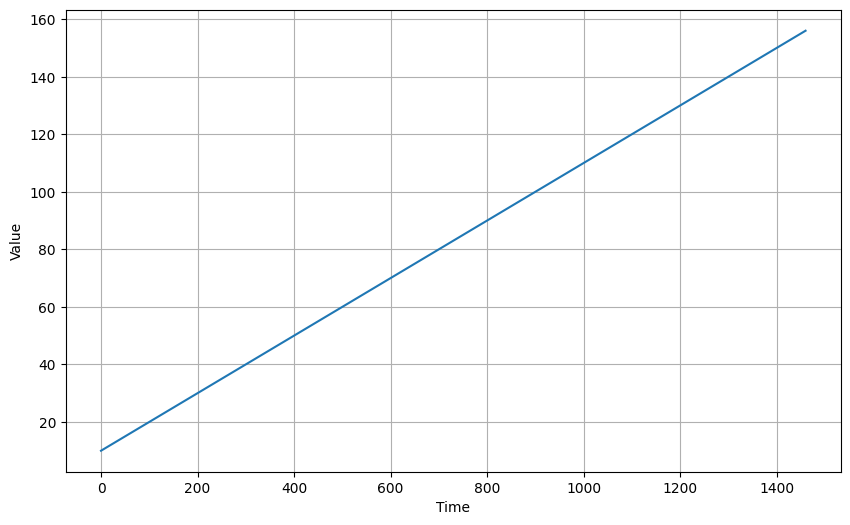

In [6]:
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

We generate the time steps using the `np.arange` function. In this case, we ask for `4 * 365 + 1` different values that start with `0`. Then we define `baseline`, which is the initial value of the time series. Our time series is equal to `baseline + trend(time, 0.1)`. The slope of `0.1` is the amount that we add to the time series every day.

The time series is not super interesting so far.

Now, let's generate a time series with a seasonal pattern.

In [7]:
# Just run:
def seasonal_pattern(season_time):
    """Just an arbitrary pattern; you can change it if you wish."""
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern in each period."""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

The `seasonal_pattern` function generates a pretty arbitrary shape (shown in the plot below). The first 40% of the pattern is just a cosine, and the remaining 60% is an inverse exponential shape.

This seasonal pattern is repeated multiple times by the `seasonality` function. In addition to `time`, it has some other arguments - `period`, `amplitude` and `phase`:

- `period` defines the time length of the pattern. (In this case, it's `365`, so the pattern is repeated every year. Since we have 4 years, the full pattern is repeated 4 times.) **Note:** Period is akin to wavelength in physics. Setting it sets the frequency of the pattern.
- `amplitude` controls how high & low the pattern gets.
- `phase` defines how much the pattern is shifted (left/right) relative to the actual time. Here, `phase` is 0, so we start at the very beginning (at time 0). If we had a different phase, then everything would be shifted to the left or to the right.

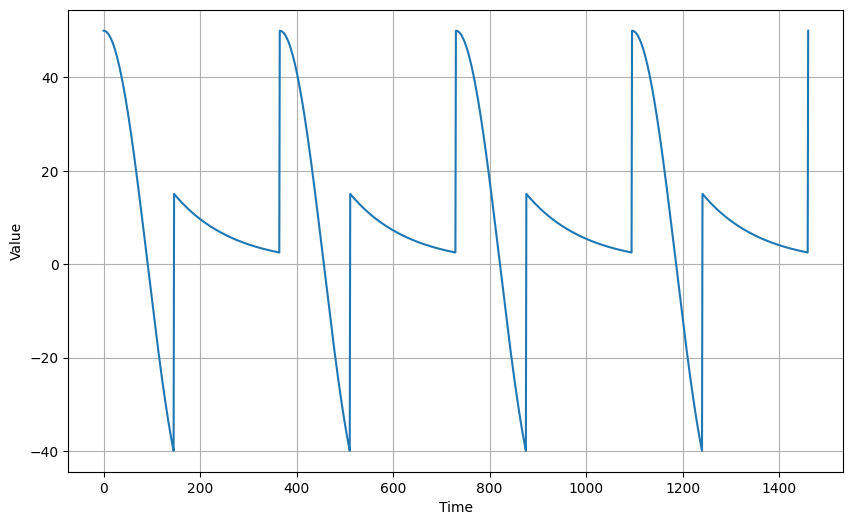

In [8]:
amplitude = 50
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

You'll find in real life that time series often have seasonal patterns. Sometimes they don't, sometimes they do, and sometimes they actually have multiple seasonal patterns. For example, think of ice cream sales. It's likely that the sales will go up every summer, and go down every winter. This is a yearly seasonality. There could also be a weekly seasonality. Maybe people tend to buy ice creams more on weekends than on weekdays. These seasonalities can overlap, and have different amplitudes. It's upto you to try to identify them, and untangle them from the rest of the time series to make studying the time series simpler.

Now let's create a time series with both trend and seasonality.

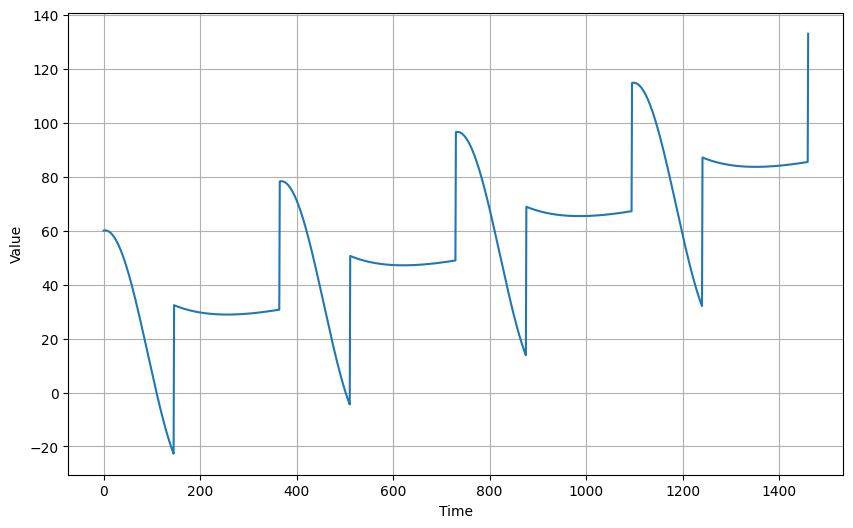

In [9]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

It's very simple. We just added the linear trend and the seasonal pattern.

### Noise

In practice few real-life time series have such a smooth signal. They usually have some noise, and the signal-to-noise ratio can sometimes be very low. Let's generate some white noise using the `white_noise` function.

In [10]:
def white_noise(time, noise_level=1, seed=None):
    return np.random.RandomState(seed).randn(len(time)) * noise_level

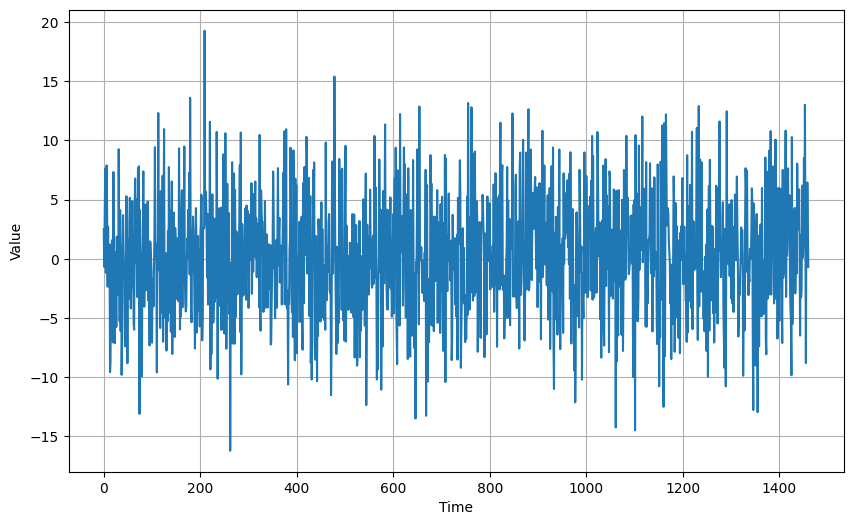

In [11]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

Here, white noise is generated by taking a random Gaussian number at every time step (and multiplying by the *noise level*, which controls the amplitude of the noise). So every piece of noise is independent of the others. This is not always the case in real life time series. The noise is often autocorrelated, meaning that it depends on its previous values. But we won't get into this complexity in this course. We'll keep using white noise.

We can see that there is not much we can do with such a noisy time series. All we can do is identify that it comes from a Gaussian distribution with mean 0. Our best bet (if we're going to try to forecast it) is to forecast 0. That's where we'll make the least error on average.

Finally, let's add this white noise to the time series.

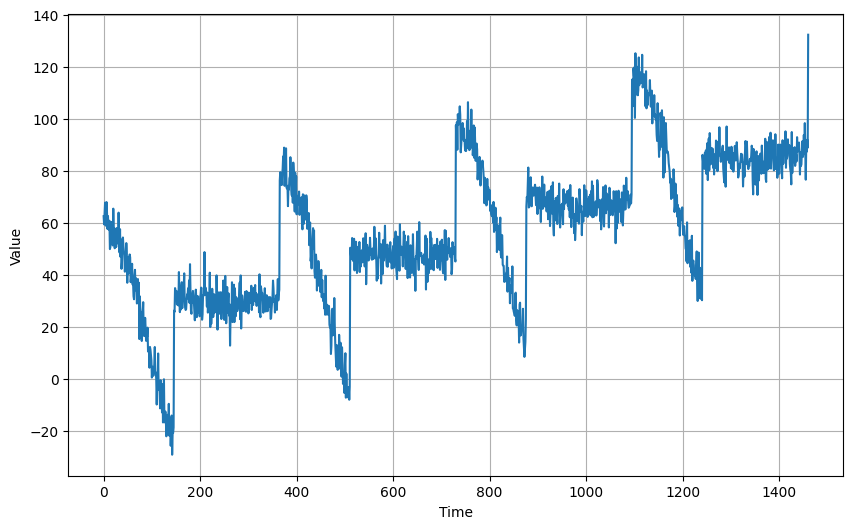

In [12]:
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

This is a fairly realistic time series with a trend, a seasonal pattern and a lot of noise.

When you're doing time series forecasting or analysis, it's often a good idea to untangle all of these components, and possibly study them separately. You can isolate the trend, you can isolate the seasonal pattern(s), and you can isolate the noise. If you do that, it will be simpler to study the whole time series, rather than studying the whole thing at once.

## V. Forecasting

The simplest approach is to take the last value, and assume that the next value will be the same. This is called *naive forecasting*.

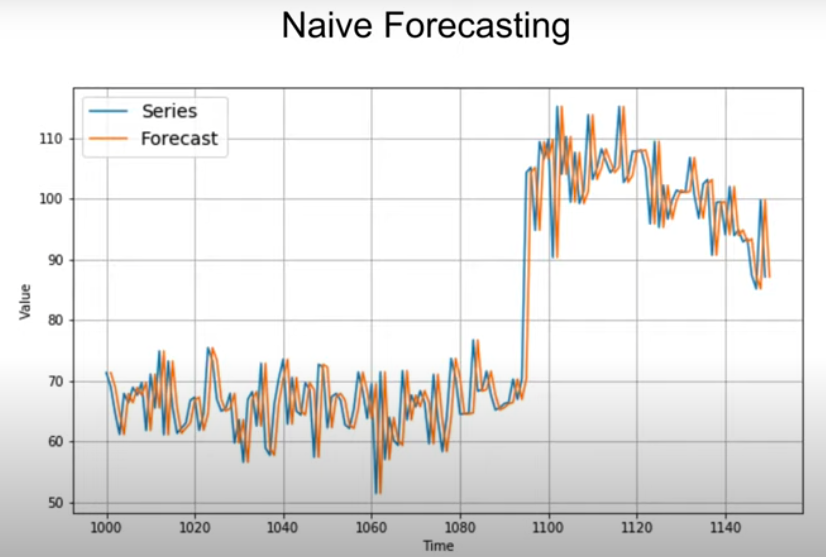

**It's often a good idea to measure the performance of naive forecasting (just to get a baseline). It's sometimes surprisingly difficult to beat.**

But how do you measure performance? To measure the performance of our forecasting model, we typically want to split the time series into a training period, a validation period and a test period.

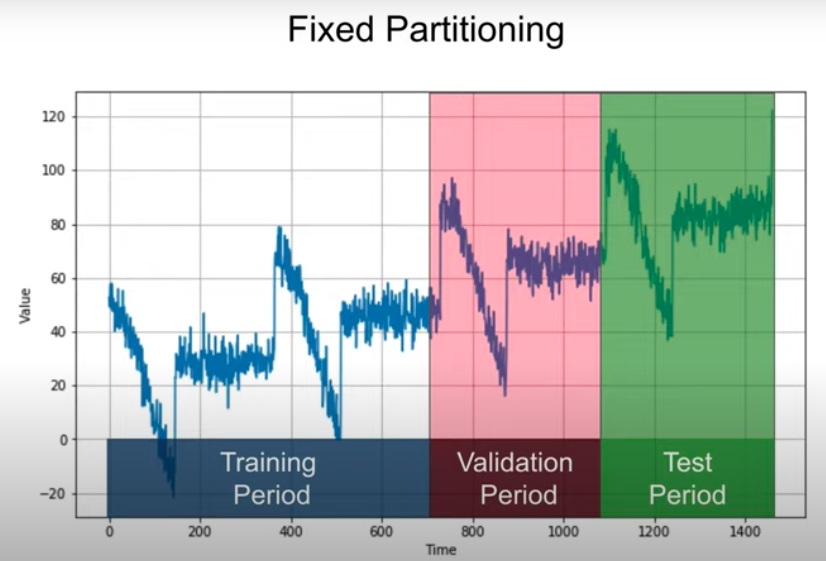

This is called *fixed partitioning*. **If the time series has some seasonality, you generally want to ensure that each period contains a whole number of seasons**, e.g., 1 year or 2 years or 3 years (if the time series has a yearly seasonality). You generally don't want 1.5 years (or else some months would be represented more than others).

Next, you train your model on the training period, and you evaluate it on the validation period. You can iterate multiple times to find the right model architecture, and tune its hyperparameters until you reach the desired performance on the validation period.

**After that, you can train your best model one more time on the whole {training + validation} period, and evaluate it on the test period** (to get an idea of how well your model will perform in production). It will not always be a very reliable estimate, because the time series may behave differently in the future. But hopefully, it will be a reasonable estimate.

**Then you can train your model one last time on the full time series** (including the test period), before you deploy your model to production. **This is different from the usual machine learning best practices, where we never train on the test set. But it's necessary for time series, because the most recent period is usually the one that contains the most useful information to predict the future.**

**Now, (i) because the test set is not as reliable as in regular machine learning, and (ii) because we need to use it for training before deploying our model, it is common to just use a training period and a validation period.** In other words, the test period is in the future.

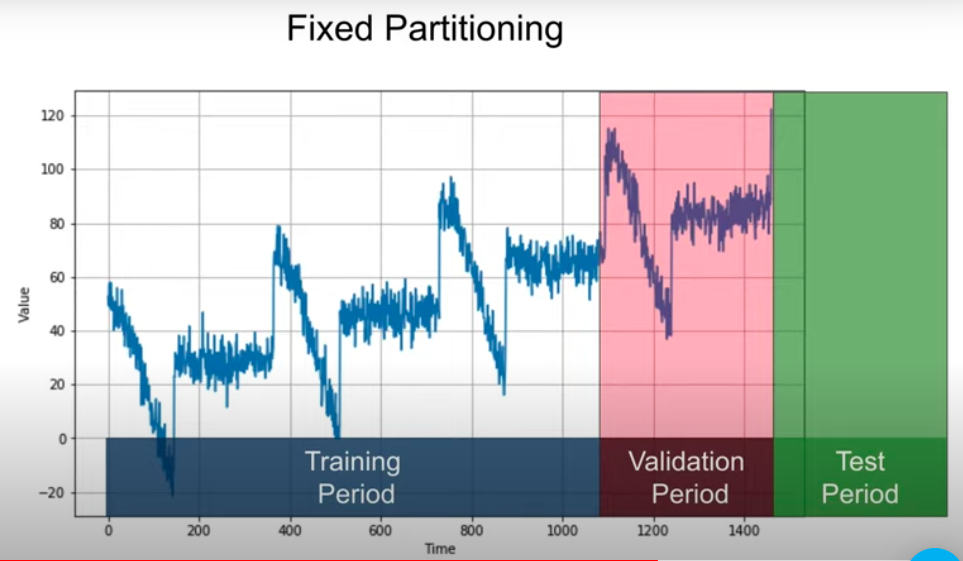

For simplicity, we will do this in the rest of this course.

Fixed partitioning is simple and intuitive. But there is another way. We start with a short training period, and we gradually increase it (say by one day / week at a time). At each iteration, we train the model on the training period, and we use it to forecast the following day / week in the validation period. This is called roll-forward partitioning.

The drawback is that it will require much more training time. But the benefit is that it will more closely mimic production conditions, since you will generally want to retrain your model regularly as you get new data in production. However, for simplicity, we will use fixed partitioning in the rest of this course.

More on roll-forward cross-validation: https://www.youtube.com/watch?v=56Nq6cs2-gc

**Note:** Apart from cross-validation, the roll-forward technique may also be used to perform transfer learning  on sequence data (similar to using progressive image resizing).

## VI. Colab: Naive Forecasting

Since we're going to do forecasting, we want to split the time series into a training period and a validation period using fixed partitioning.

In [13]:
time.shape

(1461,)

There are 1461 time steps. Let's split the time series at time step 1000.

In [14]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
time_train.shape, x_train.shape, time_valid.shape, x_valid.shape

((1000,), (1000,), (461,), (461,))

### Naive Forecast

We want to compare the naive forecast with the forecasts from the more interesting models that we'll look at later on. To do such comparisons, we want to forecast only on the validation period.

Now, what will we forecast for day 1000 (the very first day of the validation period)? Well, we're just going to copy the value from the previous day (day 999). This is why the forecast for the validation period (using naive forecasting) actually starts at `split_time - 1`. Then, we'll keep on copying all the values until we reach the last day (day 1461). For the last day, we'll copy the previous-to-last value (day 1460).

In [15]:
naive_forecast = series[split_time - 1:-1]
naive_forecast.shape

(461,)

That's naive forecasting. Pretty straight forward.

Let's plot the actual series in blue, and the forecast in orange.

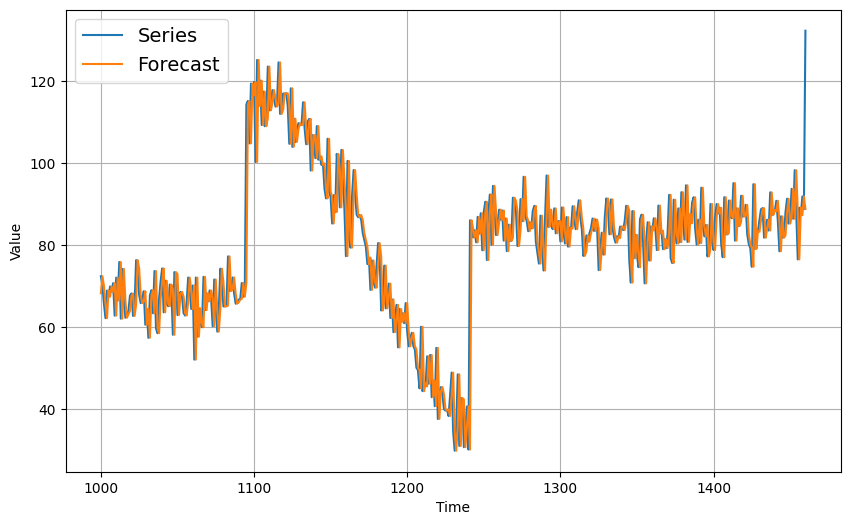

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label='Series')
plot_series(time_valid, naive_forecast, label='Forecast')
plt.show()

The actual series and the forecast overlap so well that we don't actually see the difference very well in the above plot.

Let's zoom in on the start of the validation period.

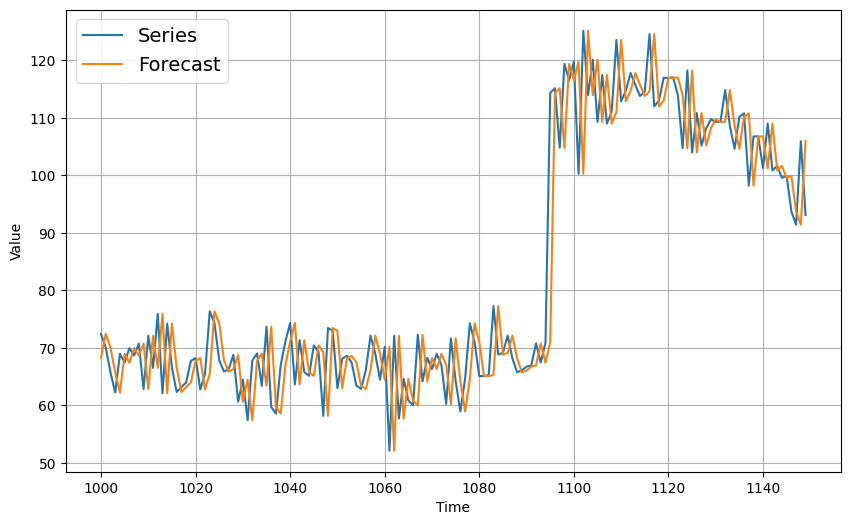

In [17]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150, label='Series')
plot_series(time_valid, naive_forecast, start=0, end=150, label='Forecast')
plt.show()

We can see that the naive forecast lags 1 step behind the time series.

How do we know whether the forecast is good or bad? For this, we need metrics.

Let's compute the mean absolute error between the forecasts and the predictions in the validation period.

In [18]:
errors = naive_forecast - x_valid
abs_errors = np.abs(errors)
mae = abs_errors.mean()
mae

6.007081936779524

There are many pre-defined functions in TensorFlow and scikit-learn. But here, we've just used NumPy to compute the MAE ourselves (very easily).

That's our baseline. In the next Colabs, we'll try to do better, starting with a moving average to remove some of the noise.

## VII. Metrics, Moving Average & Differencing

### Metrics

Once we have a model (and a period we can evaluate the model on), we need a metric.

```
errors = forecasts - actual

mse = np.square(errors).mean()

mae = np.abs(errors).mean()

mape = np.abs(errors / actual).mean()
```

The most common metric to evaluate the forecasting performance of a model is the Mean Squared Error (MSE).

Sometimes we compute the square root of the MSE, which is called the Root Mean Squared Error (RMSE). It has the advantage of having the same unit as the values in the time series. So it's easier to interpret.

Another common metric is the Mean Absolute Error (MAE), also called the Mean Absolute Deviation (MAD). It does not penalise large errors as much as the MSE.

So depending on your task, you may prefer the MAE or the MSE. For example, if large errors are potentially dangerous and cost you disproportionately more than small errors, then you may prefer the MSE. But if your gain/loss is just proportional to the size of the error, then the MAE might be a better choice.

Lastly, you can measure the Mean Absolute Percentage Error (MAPE). This is the mean ratio between the absolute error and the absolute value. This gives an idea of the size of the errors compared to the values.

Let's measure the MAE of our naive forecast on the validation period (using TensorFlow this time).

In [19]:
import tensorflow as tf

keras = tf.keras

In [20]:
keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()

6.007081936779525

We get about 6. This is our baseline.

### Moving Average and Differencing

Another simple forecasting method is to compute a moving average. **Note:** As we'll see, a slight variation of this method (i.e., moving average with a centered window) is used for de-noising a time series.

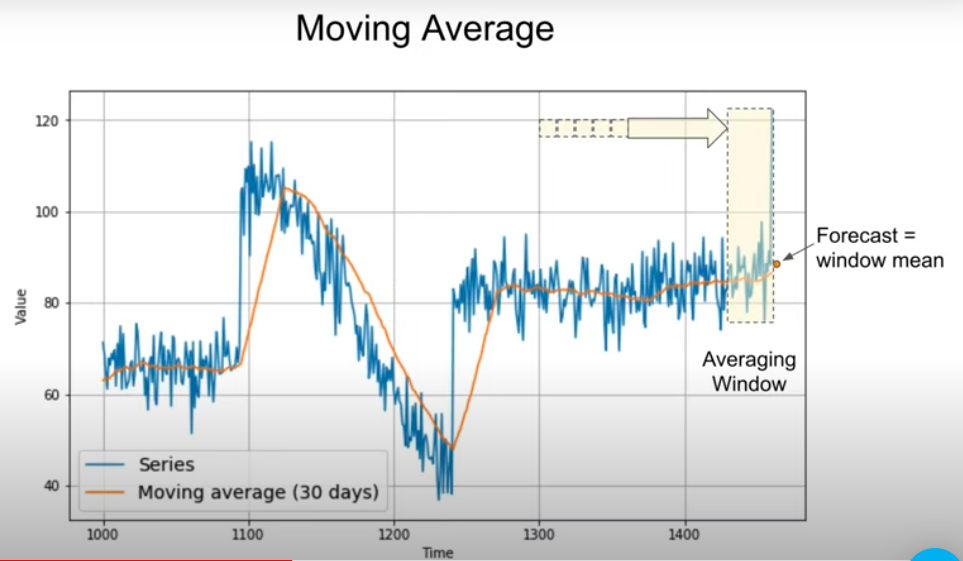

This is just the mean of the past N values, e.g., the mean value over the last 30 days. This nicely eliminates a lot of the noise. But it does not anticipate trend or seasonality. So it ends up performing worse than naive forecasting in this case. We get an MAE of about 8.2.

One way to fix this is to remove the {trend + seasonality} from the time series. For this, a simple technique is to use differencing.

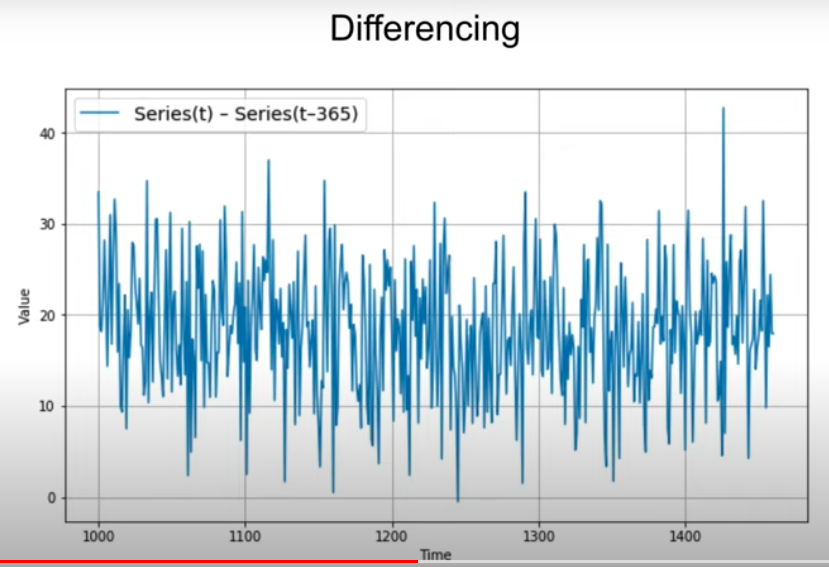

Instead of studying the time series itself, we study the difference between the value at time `t` and the value one year earlier (time `t - 365`). We get the above differenced time series, which has no trend and no seasonality.

We can then use a moving average to forecast this time series, which gives us the following forecasts.

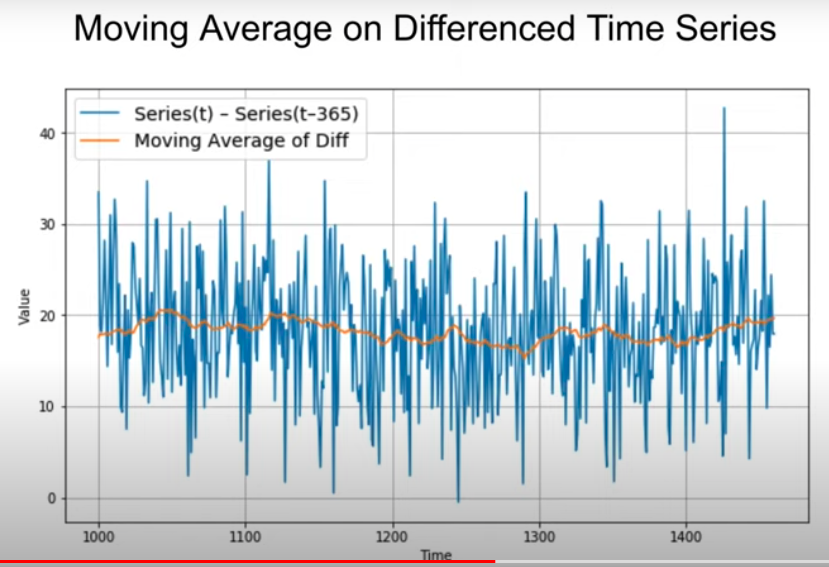

But these are just forecasts for the differenced time series, not the original time series. To get the final forecasts for the original time series, we need to add back the values at time `t - 365`. This gives us the following nice forecasts.

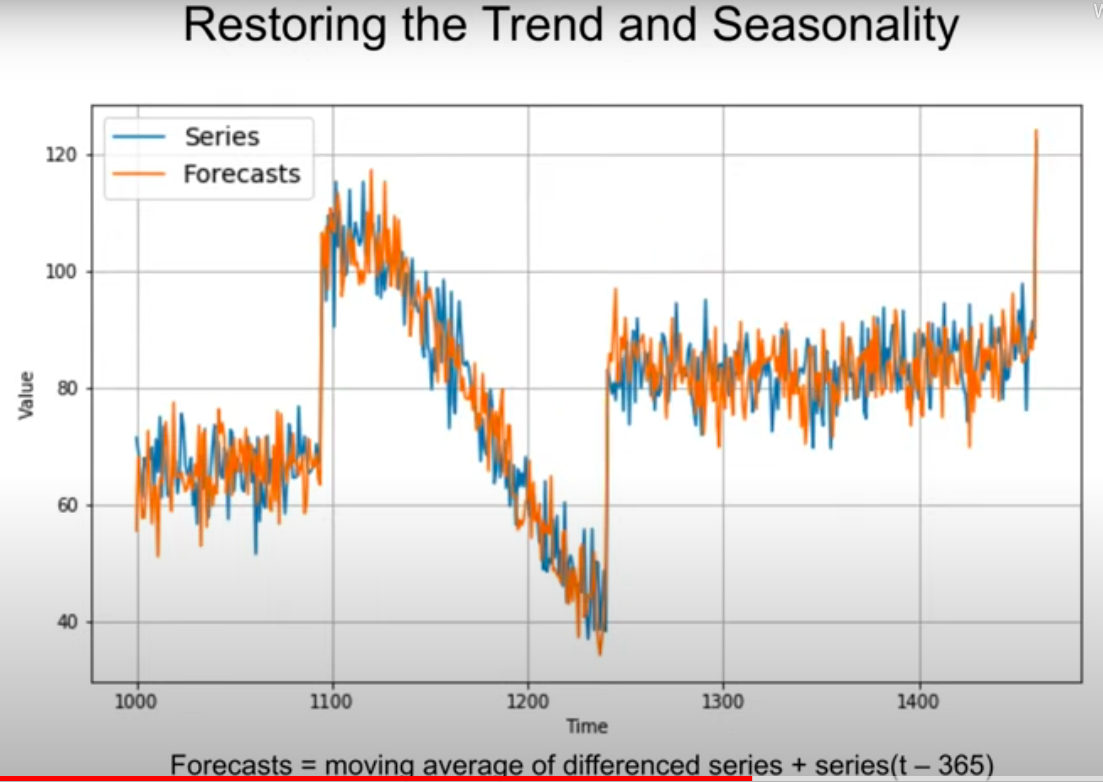

They look much better, don't they? If we measure the MAE on the validation period, we get about 5.8. So it's slightly better than naive forecasting, but not tremendously better.

You may have noticed that our moving average removed a lot of noise. But our final forecasts are still pretty noisy. Where does this noise come from? It comes from the past values that we added back to our forecasts!

We can improve these forecasts by also removing the past noise using a moving average. If we do that, we get much smoother forecasts.

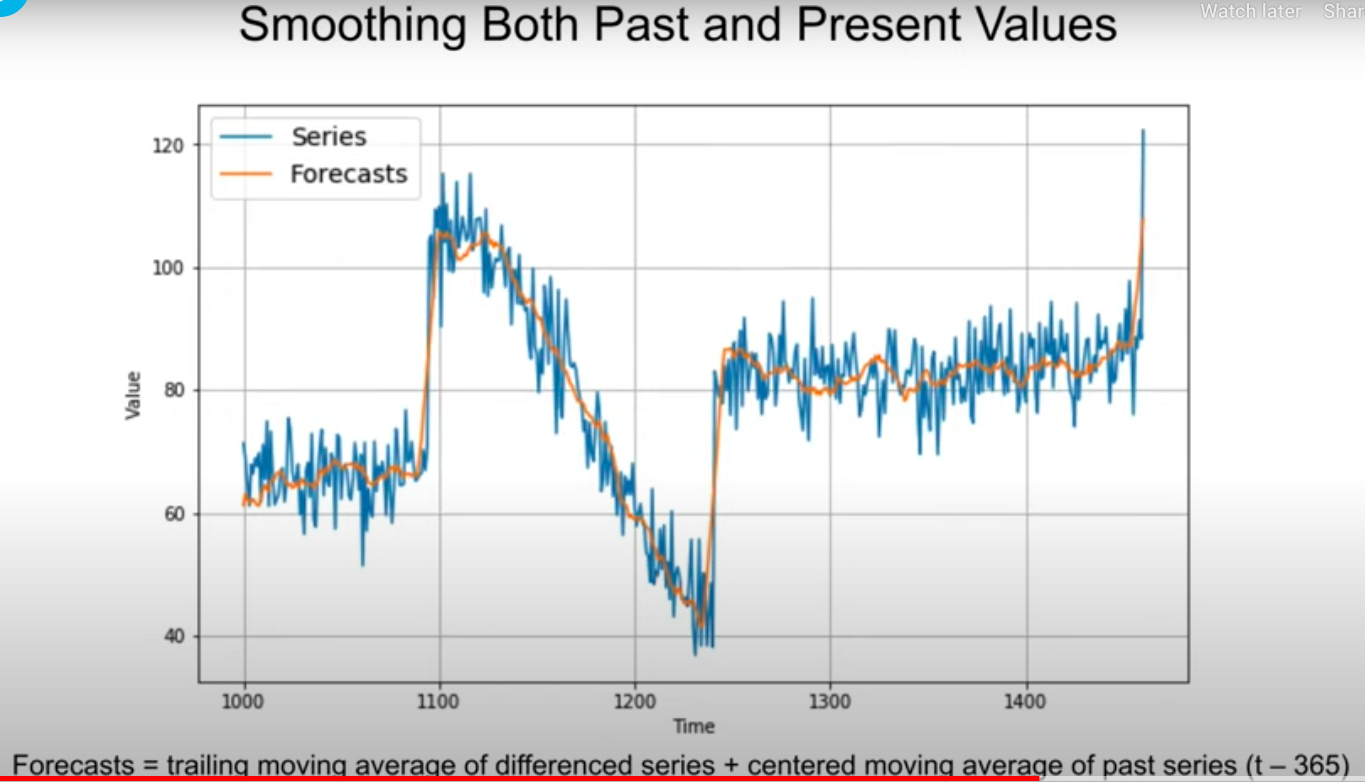

In fact, this gives us an MAE (on the validation period) of around 4.7. This is much better than all previous methods. Since the time series is generated, we can compute that a perfect model (i.e., a model which predicts the {trend + seasonality} perfectly) would get an MAE of about 4.0 (due to the noise). With this approach, it's not too far from optimal. **Keep this in mind before you rush to deep learning. Simple approaches may work just fine.**

**Note:**

1. We used a trailing window when computing the moving average of present (differenced) values (from `t - 30` to `t - 1`). But we used a centered window to compute the moving average of past values from one year ago (from `t - 365 - 5` to `t - 365 + 5`). Moving averages using centered windows are more accurate than moving averages using trailing windows. But we can't use centered windows to smooth present values, since we don't know future values. However, to smooth past values, we can afford to use centered windows.
2. There is another potential improvement we can make: create the differenced series by subtracting the centered moving average of the past series (instead of the raw past series) from the present series.

## VIII. Colab: Moving Average and Differencing

In [21]:
def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last few values.
    If window_size is equal to 1, then this is equal to naive forecast."""
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

Let's try to understand this.

First, let's examine how this function will work for `series`.

In [22]:
len(series)

1461

In [23]:
window_size = 30 # Say.

In [24]:
range(len(series) - window_size)

range(0, 1431)

`len(series) - window_size` is the number of forecasts. The larger the window size, the smaller the number of forecasts.

- When `time` is equal to `0`, we append `series[0:30].mean()`. This is the first forecast.
- When `time` is equal to `1`, we append `series[1:31].mean()`. This is the second forecast.
- ...
- When `time` is equal to `1431`, we append `series[1431:1461].mean()`. This is the last forecast.

Let's generate the whole set of forecasts.

In [25]:
series_forecast = moving_average_forecast(series, window_size=30)
len(series_forecast)

1431

Next, let's examine how this function will work for `x_valid`. Just passing `x_valid` won't do! We'll need to pass 30 days prior to `split_time` as well.

In [26]:
len(x_valid)

461

In [27]:
x_valid_for_MA = series[split_time - 30:]
len(x_valid_for_MA)

491

In [28]:
window_size = 30 # Say.

In [29]:
range(len(x_valid_for_MA) - window_size)

range(0, 461)

- When `time` is equal to `0`, we append `x_valid_for_MA[0:30].mean()`. This is the first forecast.
- When `time` is equal to `1`, we append `x_valid_for_MA[1:31].mean()`. This is the second forecast.
- ...
- When `time` is equal to `461`, we append `x_valid_for_MA[461:491].mean()`. This is the last forecast.

Let's generate the whole set of forecasts.

In [30]:
x_valid_forecast = moving_average_forecast(x_valid_for_MA, window_size=30)
len(x_valid_forecast)

461

This implementation is fairly straightforward to understand, but it's actually super slow. The next implementation is much faster (about 300 times faster). It relies on the `np.cumsum` function. I'll let you look at it more closely on your own.

In [31]:
# Just run:
def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last few values.
    If window_size is equal to 1, then this is equivalent to naive forecast.
    This implementation is *much* faster than the previous one."""
    mov = np.cumsum(series)
    mov[window_size:] = mov[window_size:] - mov[:-window_size]
    return mov[window_size - 1:-1] / window_size

Let's try it out.

In [32]:
series_forecast = moving_average_forecast(series, window_size=30)
len(series_forecast)

1431

In [33]:
x_valid_forecast = moving_average_forecast(x_valid_for_MA, window_size=30)
len(x_valid_forecast)

461

The following is an alternate way to get `x_valid_forecast`. (We're renaming `x_valid_forecast` to `moving_avg`):

In [34]:
moving_avg = moving_average_forecast(series, window_size=30)[split_time - 30:]
len(moving_avg)

461

**Explanation:** `series` has `1461` time steps, and the validation period starts at `split_time`. But `series_forecast` has `1431` time steps (the first `30` time steps have been eliminated). Hence the validation period starts at `split_time - 30`.

Let's plot the result.

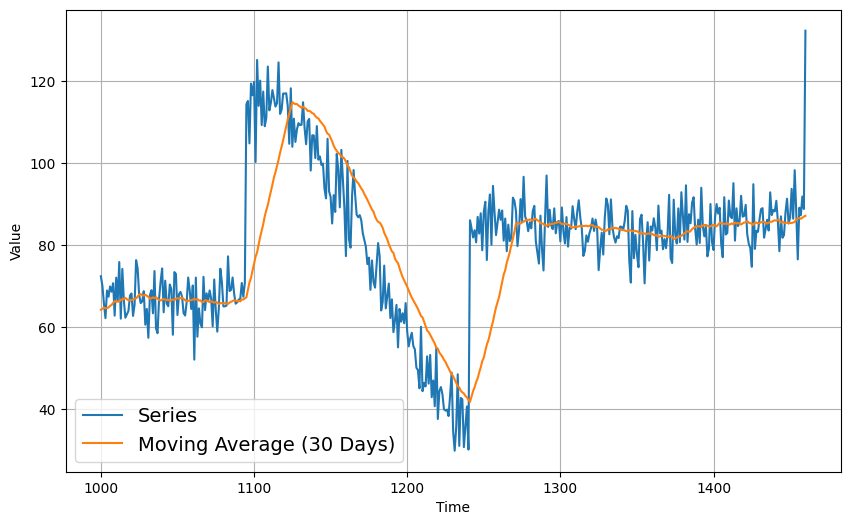

In [35]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label='Series')
plot_series(time_valid, moving_avg, label='Moving Average (30 Days)')
plt.show()

We can see that compared to naive forecasting, we get much smoother results. However, the moving average method is not anticipating the trend and seasonal pattern. So there is always a 'delay' between the forecasts and the actual values. The forecasts look pretty good when the actual values are fairly stable. However, the forecasts look particularly bad when there are big changes in the actual values.

As a result, the performance of the moving average forecast in this case is much worse than naive forecasting.

In [36]:
keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

8.247149495337542

So how can we fix this?

The moving average method does not anticipate trend or seasonality, so let's try to remove them by using differencing. Since the seasonality period is `365` days, we will subtract the value at time `t – 365` from the value at time `t`.

In [37]:
series[365:].shape # Year 1 onwards (i.e., excluding Year 0).

(1096,)

In [38]:
series[:-365].shape # Upto Year 2 (i.e., excluding Year 3).

(1096,)

**Note:** There are a total of 4 years. We're using zero indexing to refer to the years.

In [39]:
diff_series = series[365:] - series[:-365]

---

Analogy:

In [40]:
x = np.arange(4)
x

array([0, 1, 2, 3])

In [41]:
x[1:]

array([1, 2, 3])

In [42]:
x[:-1]

array([0, 1, 2])

In [43]:
x[1:] - x[:-1]

array([1, 1, 1])

---

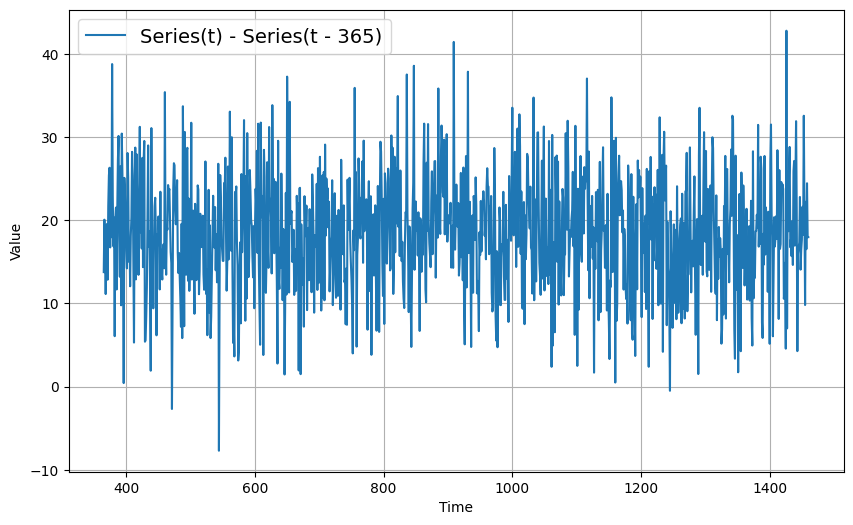

In [44]:
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series, label='Series(t) - Series(t - 365)')
plt.show()

This looks like pure noise. This may be good news, meaning that we've captured most of the signal from the time series using just differencing, and there's not much left to capture now.

Now, let's focus on the validation period.

In [45]:
series.shape

(1461,)

In [46]:
diff_series.shape

(1096,)

In [47]:
1461 - 1096

365

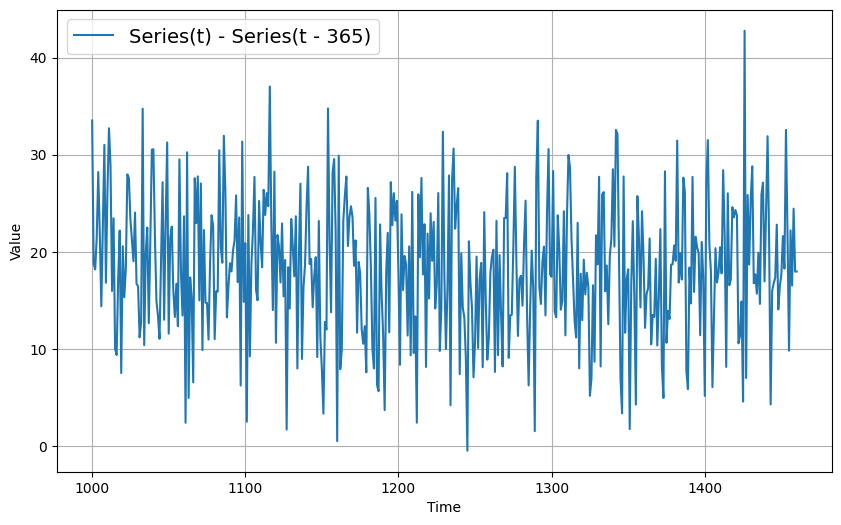

In [48]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label='Series(t) - Series(t - 365)')
plt.show()

**Explanation:** `series` has 1461 time steps, and the validation period starts at `split_time`. But `diff_series` has `1096` time steps (the first `365` time steps have been eliminated). Hence the validation period starts at `split_time - 365`.

Great, the trend and seasonality seem to be gone. Now, let's use the `moving_average_forecast` function. We'll give it the differenced time series and a window size of 50 (this is a hyperparameter you can tune). We'll also restrict our attention to the validation period.

In [49]:
diff_moving_avg = moving_average_forecast(diff_series, window_size=50)[split_time - 365 - 50:]
diff_moving_avg.shape

(461,)

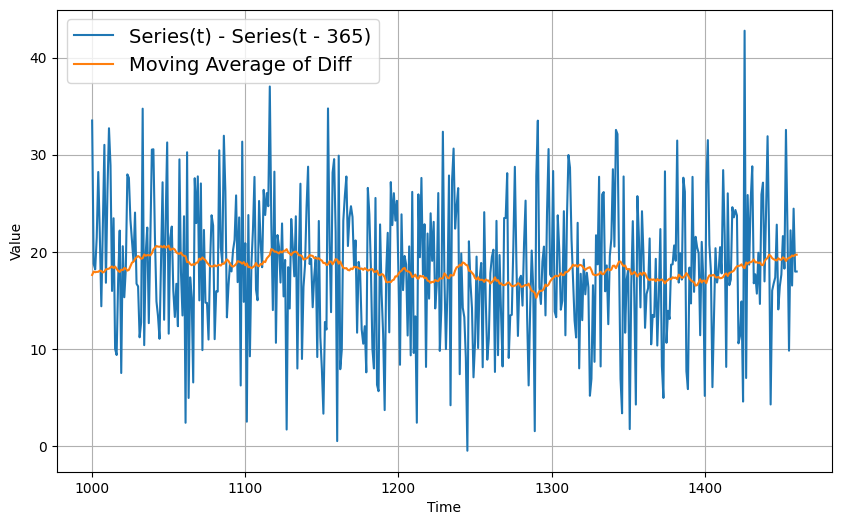

In [50]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label='Series(t) - Series(t - 365)')
plot_series(time_valid, diff_moving_avg, label='Moving Average of Diff')
plt.show()

Now let's bring back the trend and seasonality by adding the values of the time series from one year ago.

In [51]:
# Full subtracted series:
subtracted_series = series[:-365]
subtracted_series.shape

(1096,)

In [52]:
# Portion of the subtracted series which was subtracted from the validation period:
subtracted_series[split_time - 365:].shape

(461,)

**Explanation:** `series` has 1461 time steps, and the validation period starts at `split_time`. But `subtracted_series` has `1096` time steps (the first `365` time steps have been eliminated). Hence the validation period starts at `split_time - 365`.

The above line is equivalent to:

In [53]:
series[split_time - 365:-365].shape

(461,)

In [54]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

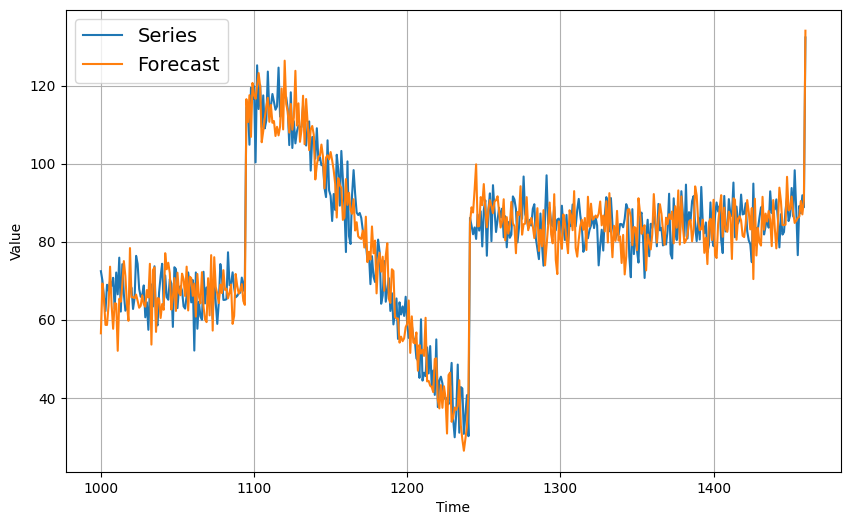

In [55]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label='Series')
plot_series(time_valid, diff_moving_avg_plus_past, label='Forecast')
plt.show()

In [56]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()

5.8393105629958955

This is better than the naive forecast, which is good. However the forecast looks a bit too random, because we're adding the past values, which were noisy.

Let's apply a moving averaging on the past values to remove some of the noise. We shall use a centered window this time.

In [57]:
series[split_time - 365 - 5:-365 + 5].shape

(471,)

In [58]:
# Window size:
5 - (-5)

10

In [59]:
471 - 10

461

In [60]:
smooth_past = moving_average_forecast(series[split_time - 365 - 5:-365 + 5], window_size=10)
smooth_past.shape

(461,)

In [61]:
diff_moving_avg_plus_smooth_past = smooth_past + diff_moving_avg

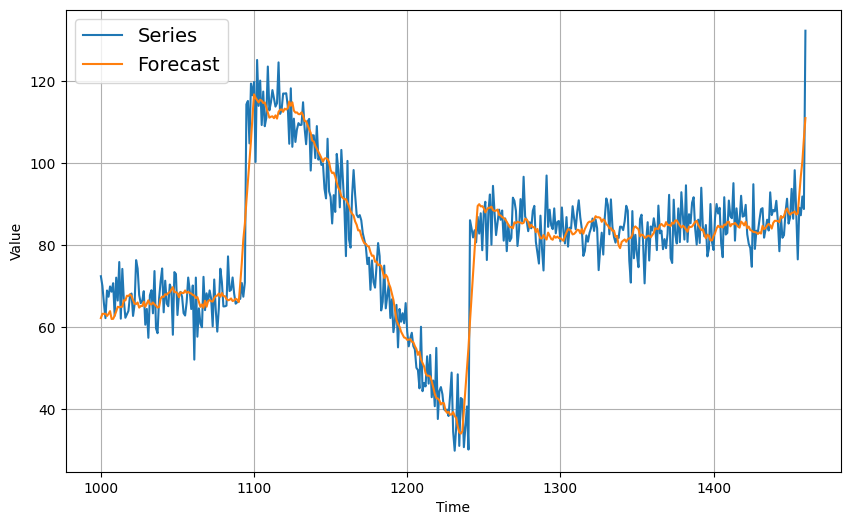

In [62]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label='Series')
plot_series(time_valid, diff_moving_avg_plus_smooth_past, label='Forecast')
plt.show()

In [63]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy()

4.708712614578918

These final forecasts do look pretty good. This also gives us the best result so far (an MAE of about 4.7).

Let's see if we can do better with a machine learning model.

## IX. Time Windows

So far we haven't talked about machine learning. Let's see how we can forecast a time series using a machine learning model.

The simplest approach is to build a model that will learn to forecast the next time step, given a time window before it.

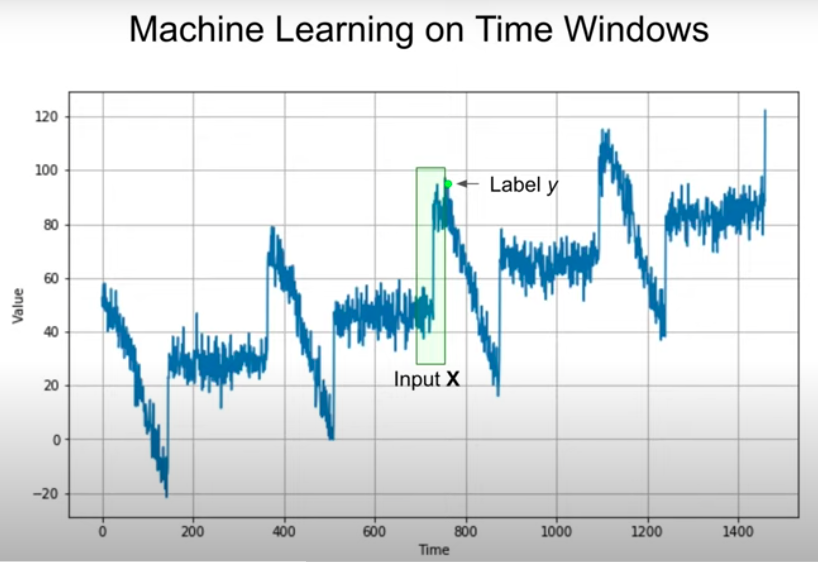

Given a time window (such as the green box above), we want the model to forecast the next time step (such as the green point above). Before we can do this, we need to choose the window size, e.g., 30 days, and we must **prepare a dataset of all possible time windows of that size**.

Let's look at how TensorFlow's `tf.data` API makes this easy. As a simple example, let's use a fake time series with just `10` time steps, and values ranging from `0` to `9`. For this, we can use the `range` method of the `tf.data.Dataset` class. We can then iterate through this dataset, and print its values. Since each element of this dataset is a `tf.Tensor`, we can get its value by calling its `numpy` method.

In [64]:
dataset = tf.data.Dataset.range(10)
dataset

<_RangeDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>

In [65]:
for val in dataset:
    print(val)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


In [66]:
dataset = tf.data.Dataset.range(10)
for val in dataset:
    print(val.numpy())

0
1
2
3
4
5
6
7
8
9


Now, let's transform this dataset to get all possible windows of `5` consecutive time steps. To do this, we call the dataset's `window` method, and specify the window length (in this case `5`). We also specify `shift=1`, so that consecutive windows will be shifted by `1` time step.

In [67]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=' ')
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


As you can see, the first window is [0, 1, 2, 3, 4], the second window is [1, 2, 3, 4, 5], and so on. The `window` method returns a new dataset containing windows.

**Note:** Each window is itself represented as a `tf.data.Dataset`. In other words, the `window` method returns a dataset of window datasets. This makes it possible to use the `tf.data` API to transform every window easily (if we ever need to). In this example, however, we just iterate over every window dataset, and print all of its values on the same line. This is done by passing `end=' '` to the `print` function.

Notice that the last few windows are shorter than `5` time steps, since we've reached the end of the series. But to train our ML models, we will generally prefer to have windows of the same length. So we will drop the last few short windows. To do this, we just need to pass `drop_remainder=True` when calling the `window` method.



In [68]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=' ')
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


As you can see, all windows now have the exact same length.

But our ML models will want windows represented as tensors, not as datasets. Let's see how we can convert each window dataset into a tensor. For this, we can call the `flat_map` method. This method takes a dataset of window datasets (such as the one returned by the `window` method), iterates through each nested dataset, and returns all of its elements one by one, so that you end up with a flat tensor directly containing all of the elements of the nested dataset.

In [69]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
    print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


The `flat_map` method takes a function as an argument. You can use this function to apply any transformation you want to each nested dataset. In our case, we want to group the elements of each window in order to get a single tensor of size `5`. We do this by calling each nested dataset's `batch` method (asking it to create batches of size `5`). Since each window dataset contains exactly `5` elements, this will produce a single batch containing a tensor of size `5`.

In the end, we get a dataset that we can directly iterate over (no need for another nested for loop), and each element is a tensor of size `5`.

But we're not quite done yet.

To train an ML model, we will need input features and targets. We can use the first four time steps as the input, and the last time step as the target. To do this, we call the dataset's `map` method. We pass it a lambda function that takes a single window tensor, and returns a tuple containing two tensors: the first tensor contains all time steps except for the last one, and the second tensor contains only the last time step.

In [70]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x, y in dataset: # Each tuple (x, y) is what used to be a single window tensor.
    print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


Now, gradient descent works best when the instances in the dataset are i.i.d. (independent and identically distributed). So let's shuffle all the windows so that each training batch contains fairly independent windows. We can do this by calling the dataset's `shuffle` method.

In [71]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
for x, y in dataset:
    print(x.numpy(), y.numpy())

[5 6 7 8] [9]
[2 3 4 5] [6]
[4 5 6 7] [8]
[1 2 3 4] [5]
[3 4 5 6] [7]
[0 1 2 3] [4]


We specify the size of the buffer that will be used for shuffling. Since the dataset is quite small, we can use a tiny shuffle buffer.

Finally, when we train an ML model, we typically provide batches of instances (instead of one instance at a time / all the instances together). So let's call the dataset's `batch` method.

In [72]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x, y in dataset:
    print('x =', x.numpy())
    print('y =', y.numpy())

x = [[4 5 6 7]
 [3 4 5 6]]
y = [[8]
 [7]]
x = [[1 2 3 4]
 [5 6 7 8]]
y = [[5]
 [9]]
x = [[0 1 2 3]
 [2 3 4 5]]
y = [[4]
 [6]]


In this simple example, we use a batch size of just `2`. But usually, you will want to use a larger batch size (typically `32`). We also call the `prefetch` method. This is important for performance, as it will ensure that while the model is working on one batch of data, TensorFlow will already be preparing the next batch in parallel. This will keep the GPU busy as much as possible.

Putting all of this together, we can create a small function that converts a time series into a dataset that we can use to train an ML model.

In [73]:
# Exploratory:
tf.data.Dataset.from_tensor_slices(series)

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.float64, name=None)>

In [74]:
def window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # dataset = dataset.map(lambda window: (window[:-1], window[-1:])) # UNSQUEEZED (like above)
    dataset = dataset.map(lambda window: (window[:-1], window[-1])) # SQUEEZED (unlike above)
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

**Note:** In TensorFlow, the target tensor doesn't have to be unsqueezed.

Unlike earlier, in the above function, we refer to `window_size` as the size of the feature tensor in each window tuple. Hence, we add `1` to account for the target tensor.

Instead of using the `range` method, we call the `from_tensor_slices` method, which creates a dataset where each item corresponds to one time step from the given time series.

We can use this function to create two datasets for our time series: one for the training period, and one for the validation period.

Let's try out the function.

In [75]:
ds = window_dataset(np.arange(40), window_size=4)
ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [76]:
for x, y in ds.take(1):
    print('x =', x)
    print('y =', y)

x = tf.Tensor(
[[11 12 13 14]
 [33 34 35 36]
 [15 16 17 18]
 [19 20 21 22]
 [23 24 25 26]
 [ 7  8  9 10]
 [24 25 26 27]
 [31 32 33 34]
 [10 11 12 13]
 [28 29 30 31]
 [14 15 16 17]
 [34 35 36 37]
 [ 5  6  7  8]
 [ 1  2  3  4]
 [29 30 31 32]
 [32 33 34 35]
 [22 23 24 25]
 [18 19 20 21]
 [27 28 29 30]
 [17 18 19 20]
 [20 21 22 23]
 [35 36 37 38]
 [25 26 27 28]
 [16 17 18 19]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [30 31 32 33]
 [ 6  7  8  9]
 [ 9 10 11 12]
 [ 0  1  2  3]
 [ 3  4  5  6]
 [21 22 23 24]], shape=(32, 4), dtype=int64)
y = tf.Tensor(
[15 37 19 23 27 11 28 35 14 32 18 38  9  5 33 36 26 22 31 21 24 39 29 20
  8 12 34 10 13  4  7 25], shape=(32,), dtype=int64)


## X. Forecasting with Machine Learning

It's time for us to build our first ML models to forecast time series. In this notebook, we'll start by building a simple linear regression model. Then, we'll move on to a dense neural network with two hidden layers.

### Linear Model

Let's start by building a simple linear regression model. For this, we can use a Keras model containing a single `Dense` layer without any activation function. Since we want to forecast a single value, we just need `1` unit.

In [77]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

We clear the Keras backend session. This is usually not needed in production code. But it's useful in Jupyter / Colab notebooks, because we keep going back to the same cells again and again. So it's useful to clear everything to make sure that we start from zero.

We also set the random seeds (both for TensorFlow and NumPy). This ensures that our results are reproducible. If we run the code multiple times, we'll get the same result.

---

From the <a href="https://www.tensorflow.org/api_docs/python/tf/random/set_seed" target="_blank">documentation</a>:

> Operations that rely on a random seed actually derive it from two seeds: the global and operation-level seeds. `tf.random.set_seed` sets the global seed.

> If the graph-level (global) seed is set, but the operation seed is not: The system deterministically picks an operation seed in conjunction with the graph-level seed so that it gets a unique random sequence. Within the same version of TensorFlow and user code, this sequence is deterministic.

---

In [78]:
window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

In [79]:
model = keras.Sequential([
    keras.layers.Dense(units=1, input_shape=[window_size])
])

This is a very simple model (defined using the `Sequential` API).

Next, we compile the model, and fit it to the training set.

We use an SGD optimizer with some momentum. This often converges much faster than a basic SGD optimizer. You could also try using other optimizers such as Adam or RMSProp.

We use Huber loss for training. It is quadratic for small errors (just like MSE), but it is linear for large errors (just like MAE). It is a good loss function to use when you want to optimize the MAE. We could use MAE directly as our loss function, but the Huber loss converges much better.

We specify MAE as our metric.

In [80]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(
    loss=keras.losses.Huber(),
    optimizer=optimizer,
    metrics=['mae']
)

In [81]:
model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100
31/31 [==============================] - 1s 10ms/step - loss: 39.0689 - mae: 39.5644 - val_loss: 20.1514 - val_mae: 20.6451
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 15.7450 - mae: 16.2347 - val_loss: 13.3390 - val_mae: 13.8314
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 13.6823 - mae: 14.1695 - val_loss: 12.2328 - val_mae: 12.7211
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 12.4193 - mae: 12.9099 - val_loss: 11.1872 - val_mae: 11.6716
Epoch 5/100
31/31 [==============================] - 0s 12ms/step - loss: 11.0728 - mae: 11.5558 - val_loss: 10.1002 - val_mae: 10.5880
Epoch 6/100
31/31 [==============================] - 0s 7ms/step - loss: 9.9185 - mae: 10.4015 - val_loss: 9.3517 - val_mae: 9.8418
Epoch 7/100
31/31 [==============================] - 0s 8ms/step - loss: 9.1816 - mae: 9.6670 - val_loss: 8.7066 - val_mae: 9.1946
Epoch 8/100
31/31 [==============================] - 1s 8ms/

---

How do we select a good learning rate? We can run our training loop several times (using different learning rates), and choose the value that gives us the best result. Alternatively, we can automate the learning rate finding process like shown below.

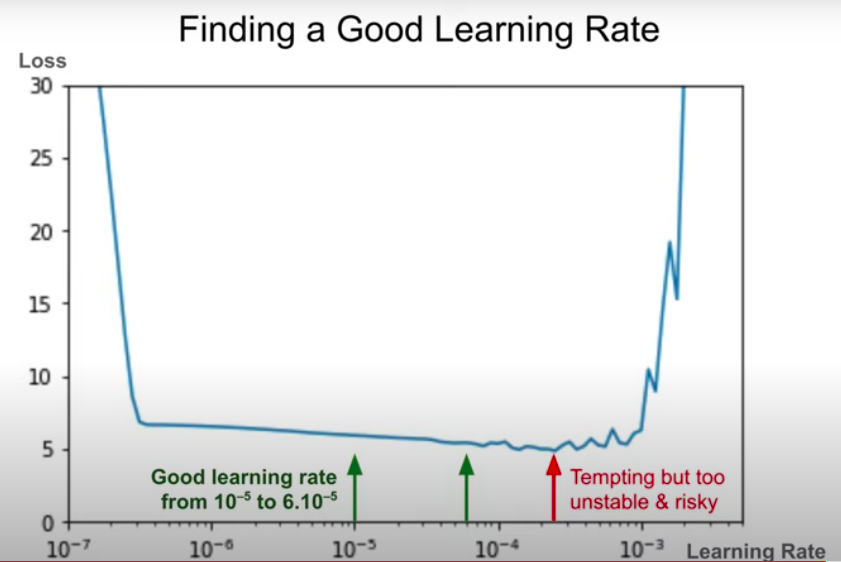

To find a good learning rate, we can start with a tiny learning rate at first, and gradually increase it until the loss starts shooting back up. The point at which it stops going down smoothly is usually a very good learning rate to use.

We can do this with the `LearningRateScheduler` callback. We tell it to vary the learning rate during training. We start with a very small learning rate of `1e-6`, and increase it gradually, so that every `30` epochs, the learning rate is multiplied by `10`.

**Note:** In the optimizer, the specified learning rate must be the same as the initial learning rate in `LearningRateScheduler`.

In [82]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [83]:
window_size = 30
train_set = window_dataset(x_train, window_size)

In [84]:
model = keras.Sequential([
    keras.layers.Dense(units=1, input_shape=[window_size])
])

In [85]:
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30)
)

**Note:** When `epoch` is `30`, `1e-6` is multipied by `10`. When `epoch` is `60`, `1e-6` is multipied by `10**2`. When `epoch` is `90`, `1e-6` is multipied by `10**3`.

In [86]:
optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(
    loss=keras.losses.Huber(),
    optimizer=optimizer,
    metrics=['mae']
)

Next, we'll train our model for `100` epochs (ensuring that we pass the instance of `LearningRateScheduler` that we created to the `fit` method).

In [87]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 4ms/step - loss: 83.0813 - mae: 83.5806 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 66.3715 - mae: 66.8714 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 47.0018 - mae: 47.5010 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 27.8295 - mae: 28.3267 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 16.4912 - mae: 16.9817 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 15.3869 - mae: 15.8756 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 15.1964 - mae: 15.6859 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 1ms/step - loss: 15.0301 - mae: 15.5192 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 14.8422 - mae: 15.3317 

We can see that our loss goes down initially, before shooting back up again. The learning rate is way too high after a point.

If we plot the learning rate and the loss, we see that the loss went down really quickly, then it went down more slowly, then it started jittering a bit, and then it exploded.

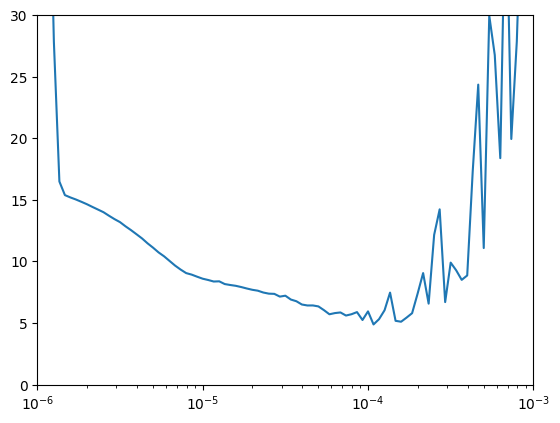

In [89]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-6, 1e-3, 0, 30]);

A good learning rate would be somewhere on the left of the unstable part. So we can pick something like `1e-5` (a pretty safe learning rate).

---

Another trick you can use for training is to use early stopping. This is another callback that you can create.

Keras will call this callback during training at the end of each epoch, and it will interrupt training when the model stops improving on the validation period. More specifically, Keras will measure the validation loss at the end of each epoch, and this callback will interrupt training if the best validation loss remains unchanged for `10` (say) consecutive epochs - the '*patience*' parameter. This is a very common and useful technique to reduce overfitting. When you use this callback, you can set the number of epochs in the `fit` method to a large value (like `500`), since training will generally stop long before that.

**Possible template:**

1. Use the Adam optimizer with a default learning rate of `3e-4` and `EarlyStopping` to discover a ballpark number of epochs.
2. Use the ballpark number of epochs and `LearningRateScheduler` to discover a good learning rate (without using `EarlyStopping` this time).
3. Use the good learning rate and `EarlyStopping` to train the final model.

In [90]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [91]:
window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

In [92]:
model = keras.Sequential([
    keras.layers.Dense(units=1, input_shape=[window_size])
])

In [93]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    restore_best_weights=True,
    verbose=1
)

In [94]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(
    loss=keras.losses.Huber(),
    optimizer=optimizer,
    metrics=['mae']
)

In [ ]:
model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 9ms/step - loss: 17.1155 - mae: 17.6053 - val_loss: 17.0372 - val_mae: 17.5279
Epoch 2/500
31/31 [==============================] - 0s 5ms/step - loss: 15.8559 - mae: 16.3433 - val_loss: 15.8126 - val_mae: 16.3036
Epoch 3/500
31/31 [==============================] - 0s 4ms/step - loss: 14.5358 - mae: 15.0276 - val_loss: 13.2682 - val_mae: 13.7574
Epoch 4/500
31/31 [==============================] - 0s 4ms/step - loss: 13.2191 - mae: 13.7080 - val_loss: 12.5381 - val_mae: 13.0304
Epoch 5/500
31/31 [==============================] - 0s 4ms/step - loss: 11.9958 - mae: 12.4830 - val_loss: 10.9178 - val_mae: 11.4093
Epoch 6/500
31/31 [==============================] - 0s 7ms/step - loss: 10.9712 - mae: 11.4578 - val_loss: 10.2816 - val_mae: 10.7688
Epoch 7/500
31/31 [==============================] - 1s 13ms/step - loss: 10.1417 - mae: 10.6284 - val_loss: 10.0786 - val_mae: 10.5712
Epoch 8/500
31/31 [==============================] - 1

That's it. After training, we have our first ML model capable of forecasting a time series. It just performs a linear combination of the past `30` values to forecast the next time step.

Now, let's write a small function that will use our model to forecast the time series over the validation period.

In [96]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

First, we create a dataset using the `from_tensor_slices` method. Each item in the dataset is a time step from the series. Next, we use the `window` method and the `flat_map` method (just like we did earlier) to produce a dataset of windows (where each window is shifted by one time step compared to the previous window).

However, this time we do not split the windows into input features and targets, and we do not shuffle the windows (since we just want to make predictions).

Next, we create batches, call `prefetch`, and finally call the model's `predict` method to get all the forecasts.

Let's call the `model_forecast` function to forecast the time series over the validation period. To do this, we must pass the trained model and the time series (starting `30` time steps before the start of the validation period, so that our forecasts will start at the first time step of the validation period). Also, we don't need to pass the last day of the validation period to `model_forecast`, because this will generate a forecast for one day into the future (i.e., one day beyond the validation period).

**Note:** This means that there is a bit of overlap between the data we use for training and the data we use to forecast on the validation period. For this reason, we should probably shorten the training period by `30` days to avoid 'peeking' into the future. But we'll ignore this issue for now. (This issue is not there in the validation metrics printed by the `fit` method, since `train_set` and `valid_set` do not overlap.)

In [100]:
model_forecast(model, series[split_time - window_size:-1], window_size).shape

15/15 [==============================] - 0s 5ms/step


(461, 1)

In [103]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]
lin_forecast.shape

15/15 [==============================] - 0s 5ms/step


(461,)

Our forecasts are two dimensional. The first dimension is the instance dimension (a.k.a. *batch dimension*). In this case, each instance is a small window of `30` time steps, and the output is the corresponding forecast for the next time step. The second dimension is the dimensionality of the forecast at each time step. Since we're forecasting a univariate time series, we used a `Dense` layer with a single neuron. So the second output dimension has a size of `1`. The slice `[:, 0]` gets rid of the second dimension, so the final `lin_forecast` array is just a 1D array containing one forecast value per time step in the validation period.

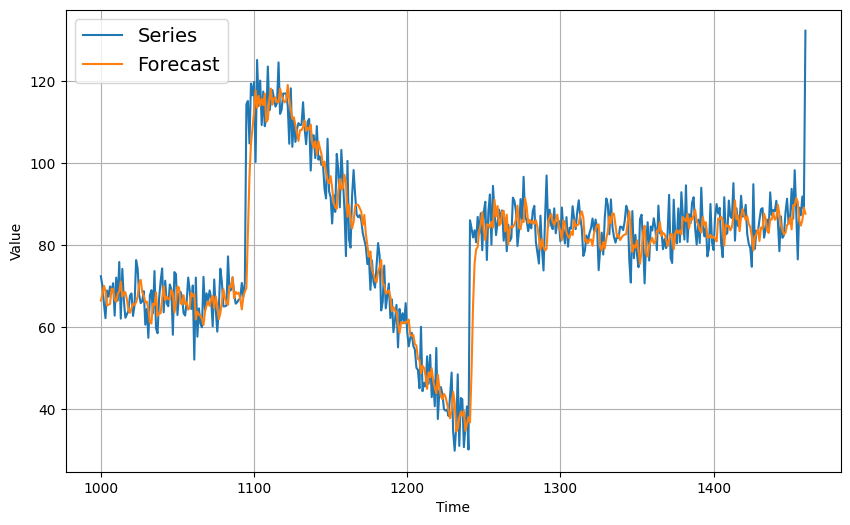

In [104]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label='Series')
plot_series(time_valid, lin_forecast, label='Forecast')
plt.show()

The forecasts track the actual values pretty well.

In [105]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

5.0496025

The MAE is about 5.1. This is much better than naive forecasting, and better than our first two moving average forecasts. But it does not beat our last moving average approach. Perhaps we can do better with a more complex model.

### Dense Model Forecasting

It's quite easy to build a dense model with two hidden ReLU layers. We can train it exactly like the linear model (except we probably want to adapt the learning rate to get the best performance).

In [106]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [107]:
window_size = 30
train_set = window_dataset(x_train, window_size)

In [108]:
model = keras.Sequential([
    keras.layers.Dense(units=10, activation='relu', input_shape=[window_size]),
    keras.layers.Dense(units=10, activation='relu'),
    keras.layers.Dense(units=1)
])

**Note:** The number of neurons in the two hidden layers are hyperparameters you can play with.

We want to find a good learning rate once again, because as soon as you change anything in the model, you need to re-discover a good learning rate.

In [109]:
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20)
)

**Note:** This time, we're starting with a lower learning rate (since our model is bigger). But we're increasing the learning rate at a faster rate (i.e., by a factor of `10` every `20` epochs).

In [110]:
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(
    loss=keras.losses.Huber(),
    optimizer=optimizer,
    metrics=['mae']
)

In [111]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 2ms/step - loss: 119.3355 - mae: 119.8349 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 117.0214 - mae: 117.5209 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 114.2912 - mae: 114.7907 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 111.3504 - mae: 111.8500 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 108.1891 - mae: 108.6884 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 104.7814 - mae: 105.2807 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 101.1351 - mae: 101.6339 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 97.2104 - mae: 97.7093 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 93.0317 -

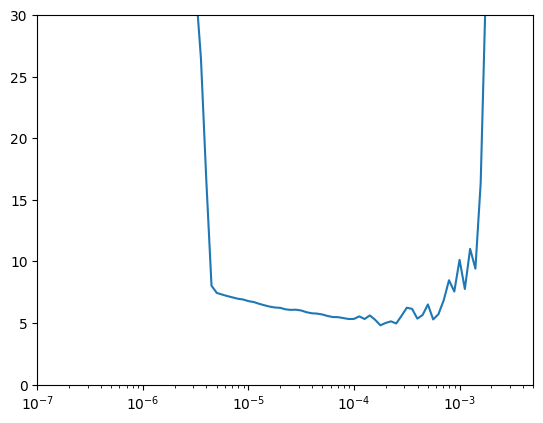

In [112]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-7, 5e-3, 0, 30]);

We see a similar pattern as earlier. Let's choose a learning rate of `1e-5`.

---

In [113]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [114]:
window_size = 30
train_set = window_dataset(x_valid, window_size)
valid_set = window_dataset(x_valid, window_size)

In [115]:
model = keras.Sequential([
    keras.layers.Dense(units=10, activation='relu', input_shape=[window_size]),
    keras.layers.Dense(units=10, activation='relu'),
    keras.layers.Dense(units=1)
])

In [116]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    restore_best_weights=True,
    verbose=1
)

In [117]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(
    loss=keras.losses.Huber(),
    optimizer=optimizer,
    metrics=['mae']
)

In [118]:
model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping])

Epoch 1/500
14/14 [==============================] - 1s 22ms/step - loss: 72.3846 - mae: 72.8833 - val_loss: 42.8389 - val_mae: 43.3383
Epoch 2/500
14/14 [==============================] - 0s 8ms/step - loss: 24.5380 - mae: 25.0354 - val_loss: 18.6555 - val_mae: 19.1536
Epoch 3/500
14/14 [==============================] - 0s 10ms/step - loss: 14.7102 - mae: 15.1982 - val_loss: 13.6264 - val_mae: 14.1151
Epoch 4/500
14/14 [==============================] - 0s 9ms/step - loss: 12.1751 - mae: 12.6662 - val_loss: 11.9631 - val_mae: 12.4529
Epoch 5/500
14/14 [==============================] - 0s 9ms/step - loss: 11.1348 - mae: 11.6203 - val_loss: 9.8231 - val_mae: 10.3117
Epoch 6/500
14/14 [==============================] - 0s 8ms/step - loss: 10.2226 - mae: 10.7121 - val_loss: 10.0187 - val_mae: 10.5054
Epoch 7/500
14/14 [==============================] - 0s 14ms/step - loss: 9.6463 - mae: 10.1340 - val_loss: 9.8980 - val_mae: 10.3866
Epoch 8/500
14/14 [==============================] - 0s

The dense model takes fewer epochs to train (compared to the linear model).

In [119]:
dense_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

15/15 [==============================] - 0s 6ms/step


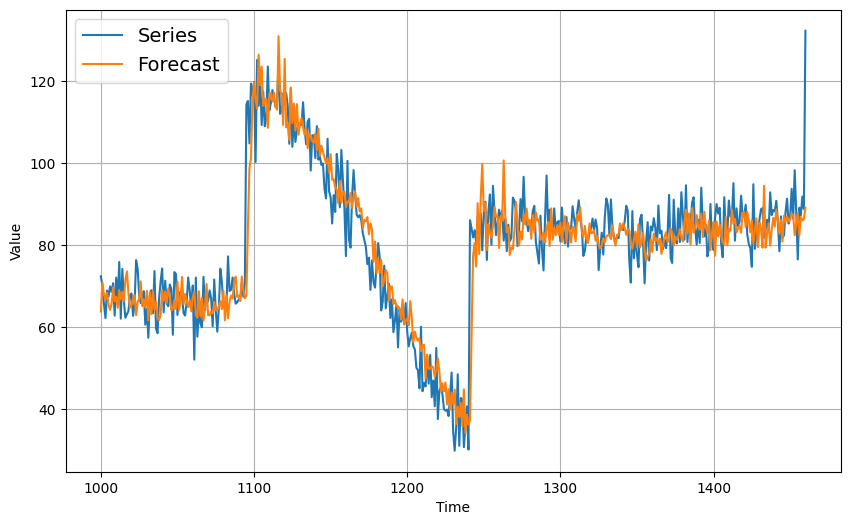

In [120]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label='Series')
plot_series(time_valid, dense_forecast, label='Forecast')
plt.show()

In [121]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

5.2371793

The dense model doesn't outperform the linear model. In fact, the MAE on the validation period is about 5.2 (slightly worse than the linear model). This is still pretty good, considering that we didn't even de-trend and de-seasonalize the data. If you remove the trend and seasonality, you should reach an even better performance.